## 3.5 Datenanalyse

Ein visueller Überblick der Daten lässt sich durch einen Plot der Entwicklung der relativen Häufigkeit der verschiedenen Fehlergruppen erzeugen:

In [1]:
# Daten aus Kapitel 5 laden
%store -r overview_datasets data_gold data_op 

# Bibliotheken laden
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import re
import os
from IPython.display import display, HTML

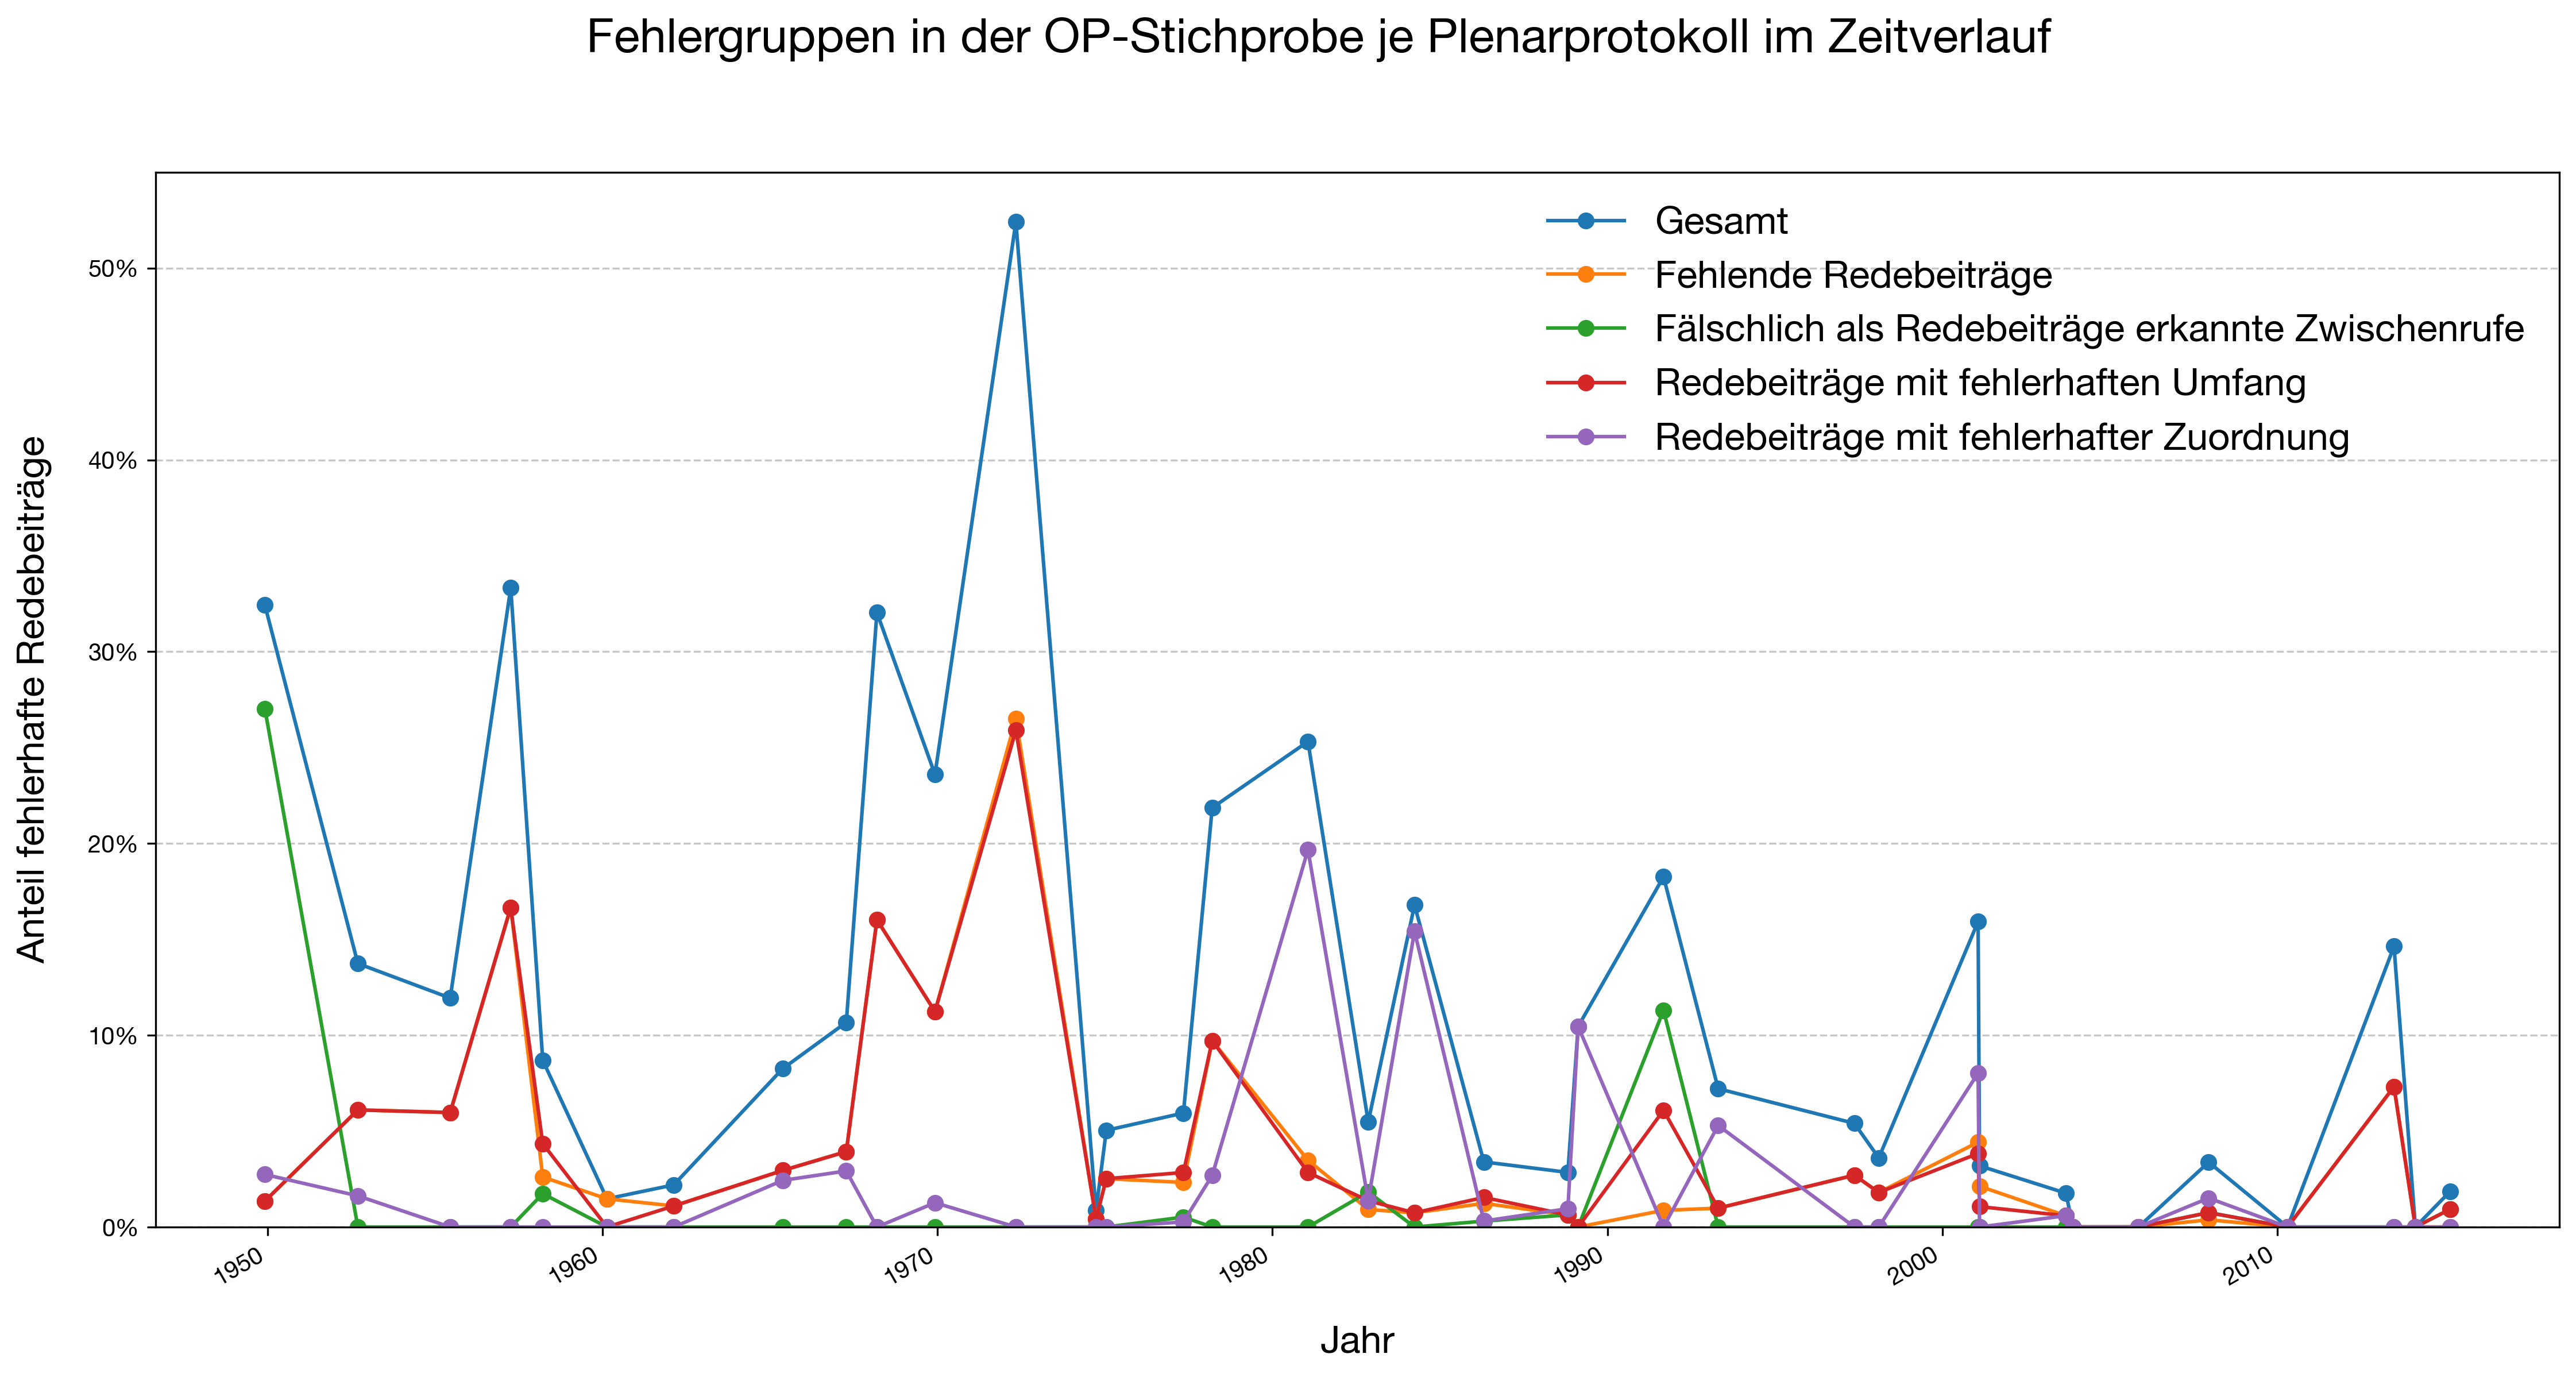

In [2]:
# Font Familiy
mpl.rc('font', family='Helvetica Neue')

# Daten-Vorbereitung
overview_plot_rel = overview_datasets[['date','wrong_total_rel','missing_rel','mistaken_rel', 'scope_rel', 'id_false_rel']].copy()
overview_plot_rel["date"] = pd.to_datetime(overview_plot_rel["date"], format="%Y-%m-%d")

# Plot mit hoher DPI-Auflösung
fig, ax = plt.subplots(figsize=[18,9], dpi=300)
overview_plot_rel.plot("date", ['wrong_total_rel','missing_rel','mistaken_rel', 'scope_rel', 'id_false_rel'], ax=ax, marker='o')

# Plot anpassen
ax.set_xlabel("Jahr", fontsize=16, labelpad=15)
ax.set_ylabel("Anteil fehlerhafte Redebeiträge", fontsize=16, labelpad=15)
# ax.set_title("Anteil fehlerhafter Redebeiträge je Protokoll in der OP-Korpus-Stichprobe", fontsize=18, pad=20)
ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')  # Format the Y-axis as percentages
ax.yaxis.set_ticks(np.arange(0, 0.61, 0.1))  # Add ticks at 10% intervals, up to 60%
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal gridlines with 70% opacity
ax.set_ylim(0, 0.55)  # Set the Y-axis range to 0 to 0.6 (or 60%)

# Legende
legend_labels = {
    'wrong_total_rel': 'Gesamt',
    'missing_rel': 'Fehlende Redebeiträge',
    'mistaken_rel': 'Fälschlich als Redebeiträge erkannte Zwischenrufe',
    'scope_rel': 'Redebeiträge mit fehlerhaften Umfang',
    'id_false_rel': 'Redebeiträge mit fehlerhafter Zuordnung'
}
ax.legend([legend_labels[col] for col in ['wrong_total_rel','missing_rel','mistaken_rel', 'scope_rel', 'id_false_rel']], fontsize=16, frameon=False, edgecolor='black')

plt.suptitle('Fehlergruppen in der OP-Stichprobe je Plenarprotokoll im Zeitverlauf', fontsize=20)

# Plot
plt.show()

Hierbei zeigt sich eine starke Varianz des Anteils fehlerhafter Redebeiträge in den verschiedenen Protokollen innerhalb der Stichprobe. Insgesamt ergibt sich über die rund 70 Jahre ein abnehmender Trend bei den Fehlerquoten.

Die Linien für die fehlenden Redebeiträge und die der Redebeiträge mit einem falschen Umfang sind größtenteils identisch. Hier liegt ein einfacher Wirkungszusammenhang vor: Das Programm für das OP-Korpus hat die Protokolle mit den RegEx-Mustern ähnlich einer Schere in ihre Redebeitrags-Einzelbestandteile zerschnitten. Wurde ein Redebeitrag nicht erkannt, ging der eigentliche Text nicht verloren, sondern wurde einfach an den Redebeitrag des:der Vorredner:in angehängt, was zu einem falschen Umfang des Redebeitrags führte.

Ein solcher Fehler ist im Close-Reading leicht erkennbar, da der Name und die Funktion des:der nachfolgenden Sprecher:in in dem Fließtext weiter vorhanden ist, gefolgt durch den Redebeitrag. Für automatische Auswertungen ist dies insofern problematisch, da Redner:innen Worte in den Mund gelegt werden, die sie nicht gesagt haben. Damit sind diese Fehlzuweisungen mindestens genauso problematisch wie die eigentlichen Nichterkennungen, wobei jede dieser entsprechend zu der doppelten Zahl fehlerhafter Redebeiträge führt.

In den wenigen Instanzen, in denen diese beiden Linien stark voneinander abweichen wie zum Beispiel 1991 in Protokoll [12037](https://dserver.bundestag.de/btp/12/12037.pdf), gibt es einen Ausschlag der fälschlich erkannten Redebeiträge. Der Grund hierfür ist, dass – in diesem Fall von Helmut Kohl – Zwischenrufe fälschlich als Redebeiträge erkannt wurden. Diese führen dazu, dass die eigentlichen Redebeiträge, die von Kanzler Kohl unterbrochen wurden, zerschnitten und jeweils der Rest des Redebeitrags fälschlicherweise Kohl zugeschrieben wurde.

Während Reden mit fehlerhaftem Umfang durch fehlende und fälschlich erkannte Redebeiträge erklärbar sind, ist es wichtig herauszufinden, weshalb Redebeiträge überhaupt fehlen oder falsch zugeordnet werden und welche Strukturen sich darin erkennen lassen.

Das entscheidende Muster für die Erkennung von Redebeiträgen ist die Beginnformel eines Redebeitrags. Für Abgeordnete beinhaltet diese den Namen des:der Redner:in und Zusatzinformationen (Fraktion, ggf. Ort, ggf. Position) und wird abgeschlossen von einem Doppelpunkt:

> Dr. Friedbert Pflüger (CDU/CSU): <br />
> Herr Präsident! Meine sehr verehrten Damen und <br />
> Herren! Der „Tagesspiegel“ in Berlin hat [...] <br /> [(19001)](https://dserver.bundestag.de/btp/19/19001.pdf)

Für die Sitzungsleitung, die Bundesregierung und den Bundesrat sehen die Formeln etwas anders aus. Zusätzlich gab es über die mehr als 70 Jahre Protokollführung kleinere Entwicklungen hinsichtlich des Musteraufbaus, hinzu kommen OCR- und Tippfehler. All diese Besonderheiten zu beachten ist dabei eine große Herausforderung.

Mithilfe des Goldstandard-Korpus lässt sich systematisch untersuchen, inwieweit strukturelle Probleme bei den Erkennungen vorlagen. Der nachfolgende Code erzeugt die Tabelle `table_error_position_group`, diese zeigt Fehler nach Akteur:innengruppen, deren absolute Zahl und den Anteil an allen Redebeiträgen dieser Gruppe:

In [3]:
table_error_position_group = pd.DataFrame()
for position_group_title in np.append(data_gold[data_gold.position_group != ""].position_group.unique(),"Gesamt"):
    # Gesamtzahl je Gruppe
    position_group = data_gold[data_gold.position_group == position_group_title] if position_group_title != "Gesamt" else data_gold
    count_position_group = len(position_group)
    rel_count_position_group = str(round(len(position_group) / len(data_gold)*100, 2)) + " %"
    
    # Fehlende Redebeiträge je Gruppe
    mistake_per_position_group = len(position_group[position_group.in_op_dataset == False])
    rel_mistake_per_position_group = str(round(mistake_per_position_group / count_position_group*100, 2)) + " %"
    
    if mistake_per_position_group != count_position_group:
        # ID-Zuordnung
        id_per_position_group = len(position_group[(position_group['id_eval'] == 'false_negative_none_match') |
                                                   (position_group['id_eval'] == 'false_positive_match_match') |
                                                   (position_group['id_eval'] == 'false_positive_match_none')])
        rel_id_per_position_group = str(round(id_per_position_group / count_position_group*100, 2)) + " %"

    
        # Beitragsumfang
        scope_per_position_group = len(position_group[position_group.correct_scope == False])
        rel_scope_per_position_group = str(round(scope_per_position_group / count_position_group*100, 2)) + " %"
    else:
        id_per_position_group = ""
        rel_id_per_position_group = ""
        scope_per_position_group = ""
        rel_scope_per_position_group = ""
    
    # Fehlerhafter Anteil gesamt
    wrong_total_position_group = len(position_group[(position_group['id_eval'] == 'false_negative_none_match') |
                                                    (position_group['id_eval'] == 'false_positive_match_none') |
                                                    (position_group['id_eval'] == 'false_positive_match_match') |
                                                    (~position_group['correct_scope']) |
                                                    (~position_group['in_op_dataset'])])
    rel_wrong_total_position_group = str(round(wrong_total_position_group / count_position_group*100, 2)) + " %"
    
    # Zusammenfügen
    error_position_group = pd.DataFrame({'Gruppe':[position_group_title],
                                           'Anzahl Redebeiträge':[count_position_group],
                                           'Anteil am Goldstandard-Korpus':[rel_count_position_group],
                                           'Fehlende Beiträge':[mistake_per_position_group],
                                           'Anteil fehlende Beiträge':[rel_mistake_per_position_group],
                                           'Fehlerhafte Zuordnung':[id_per_position_group],
                                           'Anteil fehlerhafte Zuordnung':[rel_id_per_position_group],
                                           'Fehlerhafter Beitragsumfang':[scope_per_position_group],
                                           'Anteil fehlerhafter Beitragsumfang':[rel_scope_per_position_group],
                                           'Fehlerhafte Beiträge insgesamt':[wrong_total_position_group],
                                           'Anteil fehlerhafte Beiträge insgesamt':[rel_wrong_total_position_group]})
    table_error_position_group = pd.concat([table_error_position_group, error_position_group], ignore_index=True)

# Transpose the table
table_error_position_group = table_error_position_group.transpose()

# Set the first row as column headers
table_error_position_group.columns = table_error_position_group.iloc[0]
table_error_position_group = table_error_position_group[1:]

table_error_position_group

Gruppe,Sitzungsvorstand,Bundesregierung,Abgeordnete:r,Bundesrat,Gesamt
Anzahl Redebeiträge,3131,1542,2857,16,7546
Anteil am Goldstandard-Korpus,41.49 %,20.43 %,37.86 %,0.21 %,100.0 %
Fehlende Beiträge,29,151,42,16,238
Anteil fehlende Beiträge,0.93 %,9.79 %,1.47 %,100.0 %,3.15 %
Fehlerhafte Zuordnung,0,228,20,,248
Anteil fehlerhafte Zuordnung,0.0 %,14.79 %,0.7 %,,3.29 %
Fehlerhafter Beitragsumfang,111,9,126,,246
Anteil fehlerhafter Beitragsumfang,3.55 %,0.58 %,4.41 %,,3.26 %
Fehlerhafte Beiträge insgesamt,140,388,188,16,732
Anteil fehlerhafte Beiträge insgesamt,4.47 %,25.16 %,6.58 %,100.0 %,9.7 %


Die Analyse zeigt, dass in der Stichprobe insgesamt 9,70 Prozent der tatsächlichen Redebeiträge fehlerhaft sind. Diese verteilen sich zu ähnlichen Teilen auf fehlende Redebeiträge, eine fehlerhafte Zuordnung und einen fehlerhaften Umfang. Zusätzlich gibt es 49 fälschlich als Redebeiträge erkannte Textfragmente, die in der Tabelle und Fehlerquote nicht enthalten sind.

Die Ergebnisse zeigen für Bundesrats- und Bundesregierungs-Redebeiträge starke strukturelle Probleme auf: Jeder einzelne Redebeitrag in der Stichprobe, der von Bundesrats-Vertreter:innen gehalten wurde, fehlt im OP-Korpus. Mit insgesamt nur 16 der 7546 Redebeiträge im Goldstandard-Korpus machen diese unter 1 % des Gesamtkorpus aus, dennoch sind diese Redebeiträge für bestimmte Untersuchungen offensichtlich hochrelevant.

Ebenso alarmierend ist, dass 25,16 % der Redebeiträge von Bundesregierungsvertreter:innen fehlerhaft sind. 9,79 % der Redebeiträge fehlen komplett, bei 14,79 % gibt es eine fehlerhafte Zuordnung.

### 3.5.1 Fehlende Redebeiträge
In der Stichprobe fehlen 238 der insgesamt 7546 Redebeiträge, damit wurden 3,15 % der Redebeiträge nicht erkannt. Die aus Tabelle `table_error_position_group` erkennbaren Muster hinsichtlich des Anteils fehlender Redebeiträge von 9,79 % für die Bundesregierung und 100 % für den Bundesrat erfordert einen gesonderten Blick je nach Gruppe.

Neben struktureller Fehler aufgrund der Funktion der Redner:innen, gibt es auch mehrere fehlende Redebeiträge aufgrund von Layoutextraktionsproblemen: In den beiden Protokollen [14145](https://dserver.bundestag.de/btp/14/14145.pdf) und [14150](https://dserver.bundestag.de/btp/14/14150.pdf) fehlen jeweils die ersten beiden Redebeiträge. Der Grund hierfür ist eine falsche Layoutextraktion in den Open Data des Bundestags: Der vor der Eröffnungsformel stehende Absatz mit der Sitzungsnummer, dem Datum und Ort sowie der Uhrzeit ist in beiden Dokumenten fälschlicherweise der rechten der beiden Spalten zugeordnet. Das RegEx-Muster des OP-Korpus zu Erkennung des Sitzungsbeginns nutzt jedoch diese Angabe, weshalb alle Inhalte der linken Spalte (die Eröffnung durch den Präsidenten sowie in beiden Fällen Reden von Ministern) verloren gegangen sind.


Für die Erkennung von Reden sind drei sehr lange und ausgefeilte RegEx-Muster zuständig, deren Titel die Aufteilung klarmachen `president_pattern`, `faction_speaker_pattern`, sowie `minister_pattern`. Diese werden dann zusammen mit den jeweiligen Satz der für die Periode gültigen Klammern kompiliert. Die Erkennung von Staatssekretär:innen läuft ebenfalls über die `minister_pattern`.[[1]](#ref_1)

In diesen RegEx-Mustern liegt auch die Erklärung für die fehlenden Redebeiträge. Im Folgenden werden die jeweiligen Problemfelder herausgearbeitet und ihr Effekt nach Möglichkeit im Gesamtkorpus gemessen. Diese Messungen basieren auf eigens erstellen RegEx-Mustern, um die die entsprechenden Probleme zu zählen. Für diese Zählung wird die Tabelle `table_missing_regex` erstellt und die Zählfunktion `count_missing_speeches` definiert:

In [4]:
table_missing_regex = pd.read_csv("../data/evaluation/table_missing_regex.csv", delimiter=";")
table_missing_regex["estimate"] = np.nan
for i in range (1,22):
    table_missing_regex[str(i).zfill(2)] = 0

Die Zählfunktion `count_missing_speeches()` iteriert über die Perioden und Protokolle und zählt mithilfe der übergebenen RegEx-Muster, die Häufigkeit des Vorkommens dieser Muster, was hier die Zahl fehlender Redebeiträge bedeutet. Die Fehler werden je Periode gezählt und summiert. Die Einteilung in die Bundestagsperioden und nicht Jahre ist deshalb sinnvoll, weil Protokoll-Konventionen oft mit der Legislatur-Periode geändert werden und häufig bestimmte strukturellen Probleme spezifische Redner:innen betreffen, die ebenfalls meist zu diesem Zeitpunkt wechseln.

In [5]:
def count_missing_speeches(regex_dict):
    path_source = '../data/raw'

    for period in range(1, 19):
        for file in os.listdir(path_source + "/" + str(period).zfill(2)):
            if file.endswith('.xml'):
                file_name = os.path.join(path_source, str(period).zfill(2), file)
                file_content = open(file_name).read()

                for error in regex_dict:           
                    for match in re.finditer(regex_dict[error], file_content, re.MULTILINE):
                        if  np.isnan(table_missing_regex.at[error, 'estimate']):
                            table_missing_regex.at[error, 'estimate'] = 0

                        table_missing_regex.at[error, str(period).zfill(2)] += 1
                        table_missing_regex.at[error, 'estimate'] += 1

Mit der Plot-Funktion `plot_missing()` können diese auch über die Zeit gerendert werden:

In [6]:
def plot_missing(index = None, matrix = [1,1], size=[20,5], summary = False):
    def plot_styling(title, filtered_data, data, ax):
            ax.set_title(title, loc='left')
            ax.set_title("Gesamt: " + str(np.sum(filtered_data)), loc='right')
            ax.set_xticks(range(len(data)), minor=False)
            ax.set_xticklabels(data.index, fontdict=None, minor=False)
            ax.grid(True, color='#666666', linestyle='-')
            ax.grid(True, color='#999999', linestyle='-',alpha=0.2)
            return ax
    
    plot_missing_regex = table_missing_regex[~np.isnan(table_missing_regex.estimate)].copy()
    plot_missing_regex = plot_missing_regex if index is None else plot_missing_regex.loc[index]
    plot_missing_regex["Titel"] = plot_missing_regex["position_group"] + ": " + plot_missing_regex["description"] + " (" + plot_missing_regex["problem_field"] + ")"
    
    plot_missing_regex = plot_missing_regex.loc[:, ~plot_missing_regex.columns.isin(["id", "position_group", "problem_field", "description", "period", "observations", "estimate"])]
    plot_missing_regex = plot_missing_regex.set_index('Titel').T
    
    if np.sum(matrix) > 2:
        plt.figure(figsize=(size[0], size[1]))
        plt.subplots_adjust(hspace=0.7)
        for n, error in enumerate(index):
            ax = plt.subplot(matrix[0], matrix[1], n + 1)
            plot_missing_regex.iloc[:,n].plot(ax=ax)
            ax = plot_styling(plot_missing_regex.columns[n], plot_missing_regex.iloc[:,n], plot_missing_regex, ax)
            
        if summary:
            ax = plt.subplot(matrix[0], matrix[1], len(index)+1)
            plot_missing_regex.sum(axis=1).plot(ax=ax)
            ax = plot_styling('Gesamt', plot_missing_regex.sum(axis=1), plot_missing_regex, ax)
    else: 
        plot = plot_missing_regex.plot(figsize=size)

#### 3.5.1.1 Bundesrat
Allgemein fehlen alle Muster im OP-Code die für den Bundesrat notwendig wären (z. B. Ministerpräsident:in, Minister:in, Staatsminister:in). Im Bundesregierungsmuster gibt es den Senator:innen-Titel, dieser matched jedoch nur, wenn dieser dem Namen folgt („Beate Hübner, Senatorin (Berlin):“), aber nicht, wie es hier im Korpus vorkommt, wenn er vorangestellt ist: („Senatorin Beate Hübner (Berlin):“). Im Goldstandard-Korpus fehlen dementsprechend alle 16 Redebeiträge von Vertreter:innen des Bundesrats.

Mit einer RegEx-Abfrage auf Basis dieser fehlenden Beiträge lässt sich auch eine Schätzung des Gesamtvolumens durchführen.[[2]](#ref_2)

In [7]:
regex_pattern_bundesrat = {0: r"^(?!Frag)[^[()\]]{5,40}(\(|(Minister|präsident) des Landes )(Baden Württemberg|Bayern|Berlin|Brandenburg|Bremen|Hamburg|Hessen|Mecklenburg-Vorpommern|Niedersachsen|Nordrhein Westfalen|Rheinland-Pfalz|Saarland|Sachsen|Sachsen-Anhalt|Schleswig-Holstein)\)? ?:",}
count_missing_speeches(regex_pattern_bundesrat)

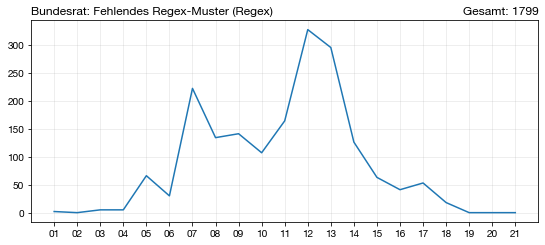

In [8]:
plot_missing([0], matrix=[2,2], size=[20,10])

**Absolute Zahl fehlender Redebeiträge von Bundesrats-Vertreter:innen im Zeitverlauf.**

Es fehlen 1799 Redebeiträge (0,2 % des gesamten OP-Korpus) und damit fast alle Äußerungen des Bundesrats, einzig 7 Redebeiträge der Bundesratspräsident:innen sind enthalten.

Damit ist jede Untersuchung im Kontext des Bundesrats im Bundestag unmöglich.

#### 3.5.1.2 Bundesregierung
Die Muster erlauben nur Großbuchstaben am Zeilenbeginn, die Redebeiträge der Staatssekretäre „von Hase“, „von Brentano“ oder „von Schoeler“ werden deshalb nicht erkannt. Ab dem Protokoll [12013](https://dserver.bundestag.de/btp/12/12013.pdf) wird auch der Vorname aufgeführt, womit dieses Problem nicht mehr auftritt. Insgesamt liegen 59 Beobachtungen im Goldstandard-Korpus vor, z. B.:[[3]](#ref_3)

> von Hase, Staatssekretär des Bundesministeriums der Verteidigung: ([05158](https://dserver.bundestag.de/btp/05/05158.pdf))

Das ausgeschriebene Wort „Parlamentarischer“ verhindert eine Erkennung, nur „Parl. Staatssekretär“ wird erkannt. Ab der Einführung des Begriffs Parlamentarischer Staatssekretär 1967 in Periode 5 ([05102](https://dserver.bundestag.de/btp/05/05102.pdf)) bis zum Ende der Periode 6 im Jahr 1972, wird er jedoch immer ausgeschrieben, danach weiterhin vereinzelt. Insgesamt liegen 49 Beobachtungen im Goldstandard-Korpus vor, alle in Periode 6, z. B.:[[4]](#ref_4)

> Hermsdorf, Parlamentarischer Staatssekretär beim Bundesminister für Wirtschaft und Finanzen: ([06185](https://dserver.bundestag.de/btp/06/06185.pdf))

Der Titel Bundesschatzminister (1962-1969) ist nicht hinterlegt und wird daher nicht erkannt. 13 Beobachtungen liegen im Goldstandard-Korpus vor, z. B.:[[5]](#ref_5)
> Schmücker, Bundesschatzminister: ([05101](https://dserver.bundestag.de/btp/05/05101.pdf))

Wenn nach dem Staatssekretärstitel in der gleichen Zeile noch Text folgt, erlaubt das Muster nur eine weitere Zeile für den Positionstitel, dies ist in manchen Fällen zu kurz. Nur wenn dagegen am Zeilenende ein Wort getrennt wird, z. B. in "Bundes-minister" wird es durch einen vorherigen Reinigungsschritt dennoch erkannt. Elf Nichterkennungen liegen im Goldstandard-Korpus vor, z. B.:
> Dr. Gerald Thalheim, Parl. Staatssekretär bei der<br/>
> Bundesministerin für Verbraucherschutz, Ernährung und<br/>
> Landwirtschaft: ([14145](https://dserver.bundestag.de/btp/14/14145.pdf))

OCR- und Tipp-Fehler in den Staatssekretär:innentiteln verhindern eine Erkennung, z. B.:
> Dr. Böhme, Parl.. Staatssekretär: ([08080](https://dserver.bundestag.de/btp/08/08080.pdf))
  
> Zander, Parl. 'Staatssekretär: ([08080](https://dserver.bundestag.de/btp/08/08080.pdf))
  
> Dr. Norbert Lammert, Parl Staatssekretär [...]: ([12152](https://dserver.bundestag.de/btp/12/12152.pdf))
  
OCR-Fehler in den Satzzeichen verhindern eine Erkennung, z. B.: 
> Genscher; Bundesminister ([08025](https://dserver.bundestag.de/btp/08/08025.pdf))
  
> Dr. Blüm: Bundesminister für Arbeit und Sozialordnung: ([10061](https://dserver.bundestag.de/btp/10/10061.pdf))
  
> Dr. von Brentano. Bundesminister des Auswärtigen: ([03018](https://dserver.bundestag.de/btp/03/03018.pdf))

Der Titel Wehrbeauftragter ist nicht hinterlegt und wird nicht erkannt, eine Beobachtung liegt dazu im Goldstandard-Korpus vor:
> Reinhold Robbe, Wehrbeauftragter des Deutschen\nBundestages: ([16133](https://dserver.bundestag.de/btp/16/16133.pdf))

Es erfolgt keine Erkennung, wenn Zwischenrufe oder Applaus direkt im Anschluss an den Namen der:der Redner:in und noch vor dem Beginn des Redebeitrags verzeichnet sind. Grundsätzlich tritt dies vor allem bei hohen Regierungsvertreter:innen auf, z. B. dem:der Bundeskanzler:in und Minister:innen, hierzu eine Beobachtung im Goldstandard-Korpus:
> Dr. Theodor Waigel, Bundesminister der Finanzen (von der CDU/CSU sowie von Abgeordneten der F.D.P. mit Beifall begrüßt): ([13176](https://dserver.bundestag.de/btp/13/13176.pdf))

Ein Redebeitrag in [04184](https://dserver.bundestag.de/btp/04/04184.pdf) von Dr. Weber (Bundesminister der Justiz) wurde nicht erkannt, da aufgrund eines Cleaning-Schritts im OP-Code vor dem Redebeitrag kein Absatz ist, was für die RegEx-Erkennung jedoch notwendig ist. In dem zuvor durchgeführten Cleaning-Schritt im OP-Code sollen Absätze innerhalb von Zwischenrufen gelöscht werden.[[6]](#ref_6)  Kurz vor der Rede befindet sich jedoch ein OCR-Artefakt, eine sich öffnende Klammer, alle darauffolgenden Absätze werden gelöscht und damit kann kein Match für die Rede stattfinden, der Text ist deshalb in der vorherigen Rede enthalten (OP-ID: 115142).

Die OCR-Fehler in Satzzeichen und die Nichterkennung wegen des OP-Cleaning-Schritts lassen sich im Gesamtkorpus nicht nachzeichnen. Für die anderen Fehlergruppen lassen sich die fehlenden Redebeiträge jedoch gut mithilfe von RegEx-Formeln abschätzen.

In [10]:
regex_pattern_bundesregierung = {1: r"^.{0,4}von[^.,()]*?, (Parl.|Parlmentarischer)? ?Staatssekretär[^.,()]*?:",
                                 2: r"Parlamentarischer Staatssekretär[^.,()]*?:",
                                 3: r"^.{0,40}?, (Parl. |Parlamentarischer )?Staatssekretär[^-.:(\d]{0,20}?\n[^-.:(\d]{0,65}?\n[^.:(\d]{0,65}:",
                                 4: r"^.{5,40}, (Pari. S|Parl .S|Parl, S|Parl\. 'S|Parl S)[^.,([]{8,40}\n?[^.,([]{0,50}:",
                                 6: r"^.{5,35}, Wehrbeauftragter[^.,()]*?(\n[^-.:(\d]{0,65})?:",
                                 7: r"^.{5,35}, [^.,()]*?(\n[^-.:(\d]{0,65})?\(.*?mit.*?\):",}
count_missing_speeches(regex_pattern_bundesregierung)

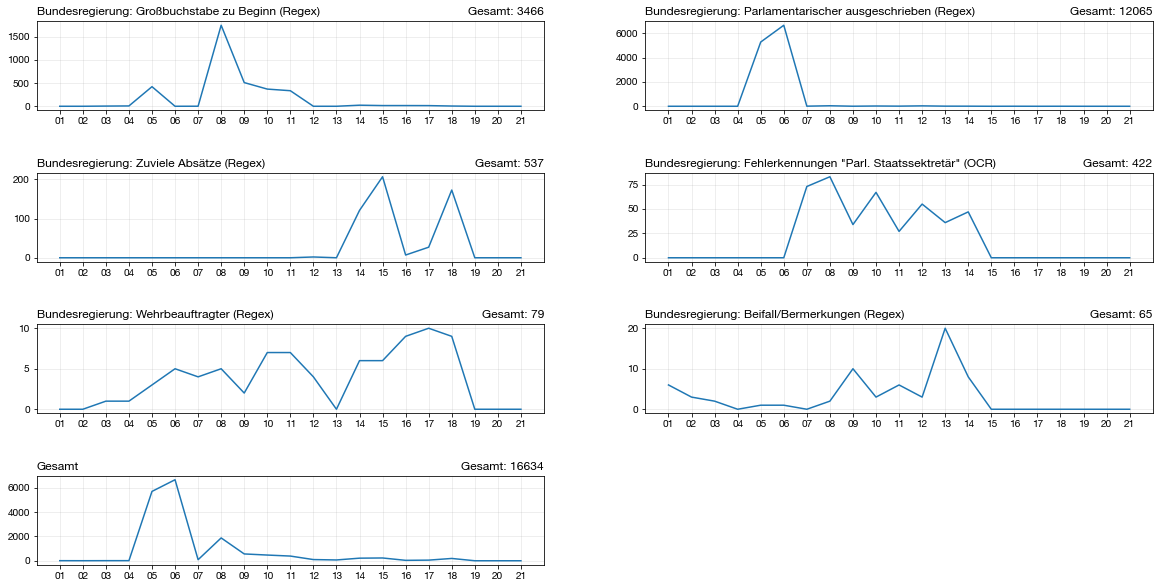

In [11]:
plot_missing([1,2,3,4,6,7], matrix=[4,2], size=[20,10], summary = True)

**Absolute Zahl fehlender Redebeiträge von Bundesregierungs-Vertreter:innen im Gesamtkorpus nach Fehlerursache im Zeitverlauf.**

Der zahlenmäßig gravierendste Fehler ist, dass im Redebeitrags-RegEx-Muster die ausgeschriebene Titelteilbezeichnung „Parlamentarischer“ fehlt, über 12.000 Redebeiträge sind hiervon betroffen. Der Großteil davon in Periode 5 und 6, bis in Periode 7 auf die verkürzte Form „Parl.“ umgestellt wurde, was wiederum mehr als 422 fehlende Redebeiträge aufgrund von mangelhaften OCR-Erkennungen nach sich zieht.

Die Umstellung von OCR-gescannten Dokumente auf digital erstellte PDFs von der 13. auf die 14. Periode führt nicht direkt zu einer allgemeinen Verbesserung der Datenqualität. Natürlich verschwinden die OCR-Fehler weniger, dafür entstehen aber neue Probleme, wie die Verarbeitung von zu vielen Absätzen. Grundsätzlich sind die RegEx-Regeln eine deutlich größere Herausforderung als die OCR-Qualität; dabei könnten die verbliebenen OCR-Fehler mit leichten RegEx-Anpassungen ebenfalls aufgefangen werden.

Untersuchungen, die die Bundesregierung betreffen, sind damit immer mit der Problemstellung konfrontiert, dass im Durchschnitt rund 10 % der Regierungs-Redebeiträge gänzlich fehlen. Tatsächlich zeigen die Plots jedoch eindrucksvoll, dass die Zahl fehlender Redebeiträge in der Stichprobe periodenspezifisch stark variieren.

In der Periode 6 (1969-1972) fehlen mindestens 6.600 Redebeiträge, die insgesamt 35.575 erkannten Redebeiträgen gegenüberstehen. In der Stichprobe stammen über alle Perioden 20,4 % der Redebeiträge von Vertreter:innen der Bundesregierung. Auf Basis dessen lässt sich die Fehlquote für diese in der 6. Periode schätzen: fast 80 % der Regierungs-Redebeiträge fehlen, analog sind es in der 5. Periode fast 50 %. Dagegen fehlen beispielsweise in der Periode 7 wie auch 17 schätzungsweise nur 1 % der Regierungs-Redebeiträge.

In [12]:
dataset_open_discourse = pd.read_feather("../data/open_discourse/speeches.feather")

In [13]:
missing_06 = sum(table_missing_regex[table_missing_regex.position_group == "Bundesregierung"]["06"])
op_06 = len(dataset_open_discourse[dataset_open_discourse.electoralTerm == 6])
print(str(round(missing_06 / ((missing_06 + op_06) * 0.2)*100, 1)), "%")

78.8 %


Bei den der Schätzung zugrunde liegenden Zahlen und den Plots ist zu beachten, dass diese die Fehlquote nicht vollständig erklären, sondern nur diejenigen, für die Testmuster vorliegen.

#### 3.5.1.3 Abgeordnete
Insgesamt 42 fehlende Redebeiträge entfallen auf die Abgeordneten, das sind 1,47 % aller Abgeordneten-Redebeiträge, die nicht enthalten sind. Dabei lassen sich zwei große Problemstellungen erkennen: Funktionsbeschreibungen (18 Redebeiträge) und in der OP-RegEx-Regel unerlaubte Kleinbuchstaben am Nachnamensanfang (8). Die weiteren 16 verteilen sich auf unterschiedliche RegEx-, OCR-, Form- und Tippfehler, die hier aufgeführt sind. Ein RegEx-Fehler sticht dabei heraus, da dieser dazu führt, dass der Großteil der Redebeiträge der DP/FVP-Fraktion im Zeitraum März bis September 1957 fehlt und die entsprechenden Redetexte dem:der vorherigen Sprecher:in zugeordnet sind.

In den Perioden 1 und 2 wurde bei den Abgeordneten, die als Berichterstatter:innen oder Antragssteller:innen fungierten, dies als Funktion angegeben. Im OP-Code ist im RegEx-Muster minister_pattern_str zwar „Berichterstatter“ enthalten, dieses matched jedoch nicht, da keine Klammern vor dem Begriff vorkommen dürfen – was bei Abgeordneten aufgrund der Fraktionsangabe aber der Fall ist. Im Abgeordneten-Muster selbst ist dieser Sonderfall gar nicht vorgesehen, plausibel sind bis zu 2900 fehlende Redebeiträge, hauptsächlich in Periode 1 und 2, vereinzelt auch in Periode 3, 4 und 5.[[7]](#ref_7) In der der Stichprobe gibt es 18 dieser Fehler, die sich alle auf Periode 1 und 2 verteilen, z. B.:

> Ritzel (SPD), Berichterstatter: ([02087](https://dserver.bundestag.de/btp/02/02087.pdf))

> Frau Kalinke (DP), Antragstellerin: ([01229](https://dserver.bundestag.de/btp/01/01229.pdf))


Das Muster `faction_speaker_pattern` erlaubt für Abgeordnete ebenfalls keinen kleinen Buchstaben zu Beginn des Nachnamens, ausgenommen sind Abgeordnete mit Dr.-Titel:

> von der Heydt Freiherr von Massenbach (CDU/ CSU) : ([08080](https://dserver.bundestag.de/btp/08/08080.pdf))

> de Terra (CDU/CSU) : ([07140](https://dserver.bundestag.de/btp/07/07140.pdf))

> von Thadden (Fraktionslos): ([01229](https://dserver.bundestag.de/btp/01/01229.pdf))

Das RegEx-Muster enthält die möglichen Fraktionsnamen für ein Match, außer den Fraktionsname der „DP [FVP]“. Dadurch fehlen alle Reden aus der Zeit der Existenz dieser Fraktion von März bis September 1957, durch eine einfache Suche („DP [FVP]):“) ergeben sich mindestens 162 fehlende Reden im OP-Gesamtkorpus. Auch die DPB (ein Redebeitrag im Gesamtkorpus) und die BHE fehlt (sieben im Gesamtkorpus, bevor sie zur GB/BHE wurde):

> Schneider (Bremerhaven) (DP [FVP]): ([02202](https://dserver.bundestag.de/btp/02/02202.pdf))

In der OP-Text-Vorverarbeitung werden am Zeilenende Trennungsstriche und der Absatz entfernt, um Worttrennungen aufzuheben. Bei dialoghaften Unterbrechungen in Redesituationen kann dies dazu führen, dass der folgende Beitrag nicht mehr nach einem Absatz steht und dementsprechend nicht erkannt wird, da diese mit zwei Geviertstrichen gekennzeichnet werden, drei Beobachtungen, z. B.:

> Dr. Bucerius (CDU/CSU) : Herr Abgeordneter, Sie erhalten erstens das Recht, mich mit Herr Bucerius anzureden. Zweitens — — <br/>
> Dr. Maier (Stuttgart) (FDP): Ich habe aber keinen so schönen Namen wie Sie. Deshalb! ([03018](https://dserver.bundestag.de/btp/03/03018.pdf))

> Vizepräsident Westphal: Nein, das geht nicht, Herr Abgeordneter. Wir sind in einer Aktuellen Stunde und halten das sehr genau ein. Ich bitte Sie deshalb — — <br/>
> Stommel (CDU/CSU): Ich bedaure sehr, meine Damen und Herren, daß ich dazu nicht noch etwas sagen kann. ([10213](https://dserver.bundestag.de/btp/10/10213.pdf))

> Präsident D. Dr. Gerstenmaier: Das freut den Kollegen Seidl ausnehmend, daß Sie — - <br/>
> Kurlbaum (SPD) : Sind Sie nicht bereit, zuzugeben, daß die ([04184](https://dserver.bundestag.de/btp/04/04184.pdf))

Durch fehlerhafte Layoutextraktion in den Bundestags-Daten wurden fälschlich Absätze entfernt, wodurch das RegEx-Muster nicht matched. Anfällig hierfür sind kurze Redebeiträge, die wenig inhaltliche Bedeutung haben:
> Vizepräsidentin Renate Schmidt: Und dann ja? Birgit Homburger (F.D.P.): Danach gern. Vizepräsidentin Renate Schmidt: Gut. ([12152](https://dserver.bundestag.de/btp/12/12152.pdf))

> Seidl (München) (CDU/CSU) : Bitte. Kurlbaum (SPD) : Herr Minister — — ([04184](https://dserver.bundestag.de/btp//.pdf))

> (Heiterkeit) Oostergetelo (SPD): Das ist zu schön. ([10213](https://dserver.bundestag.de/btp/10/10213.pdf))

Daneben gibt es auch hier einige wenige OCR-Fehler:
> Dr. Reischl SPD): ([04184](https://dserver.bundestag.de/btp/04/04184.pdf)) 

> Dr. Schneider (Nürnberg) (CDU/CSU) . ([06027](https://dserver.bundestag.de/btp/06/06027.pdf))

Layoutartefakte vor dem Redebeginn führen ebenfalls zu Nichterkennungen. Diese wurden zwar im OP-Korpus entfernt, dabei bleibt jedoch mindestens ein Leerzeichen übrig, was ein Matching verhinderte:
> (C)(A) Heino Wiese (Hannover) (SPD): Es ist nur ein Satz: ([14145](https://dserver.bundestag.de/btp/14/14145.pdf))

Tippfehler im Originaldokument führen ebenfalls zu Nichterkennungen, beispielsweise wenn die schließende Klammer vergessen wurde:
> Bading (SPD: ([04015](https://dserver.bundestag.de/btp/04/04015.pdf))

> Wolfgramm (Göttingen) (FDP: ([08025](https://dserver.bundestag.de/btp/08/08025.pdf))

Formfehler im Originaldokument sind ebenso eine Fehlerquelle, wie hier eckige, anstatt runder Klammern:
> Simone Violka [SPD]: ([14150](https://dserver.bundestag.de/btp/14/14150.pdf))

Auch eine fehlende Fraktionsangabe stellt einen Formfehler im Originaldokument dar, der zur Nichterkennung führt:
> Kiesinger: Bitte sehr! ([03018](https://dserver.bundestag.de/btp/03/03018.pdf))

Mithilfe von RegEx-Mustern können die Fehler auch wieder im Gesamtkorpus gezählt werden:

In [14]:
regex_pattern_abgeordnete = {8: r"^.{0,70}, (Antragsteller(in)?|Berichterstatter(in)?):",
                             9: r"^(von|de |van)[^:\n)\]]{0,50}?\([^)\n\]]{1,15}\) ?:",
                             10: r"DP \[FVP\]\):",
                             11: r"(—|-) (—|-)\n(?!\(|Vize|Prä).*?:",
                             12: r"^(?!\().{10,35}:.{2,20}[.!?].{10,35}:[^\d]{2,20}[.!?](?!\))",
                             14: r"^(\( ?(C|A|D|B) ?\)){1,2}[^:\n\d]*?\):"}
count_missing_speeches(regex_pattern_abgeordnete)

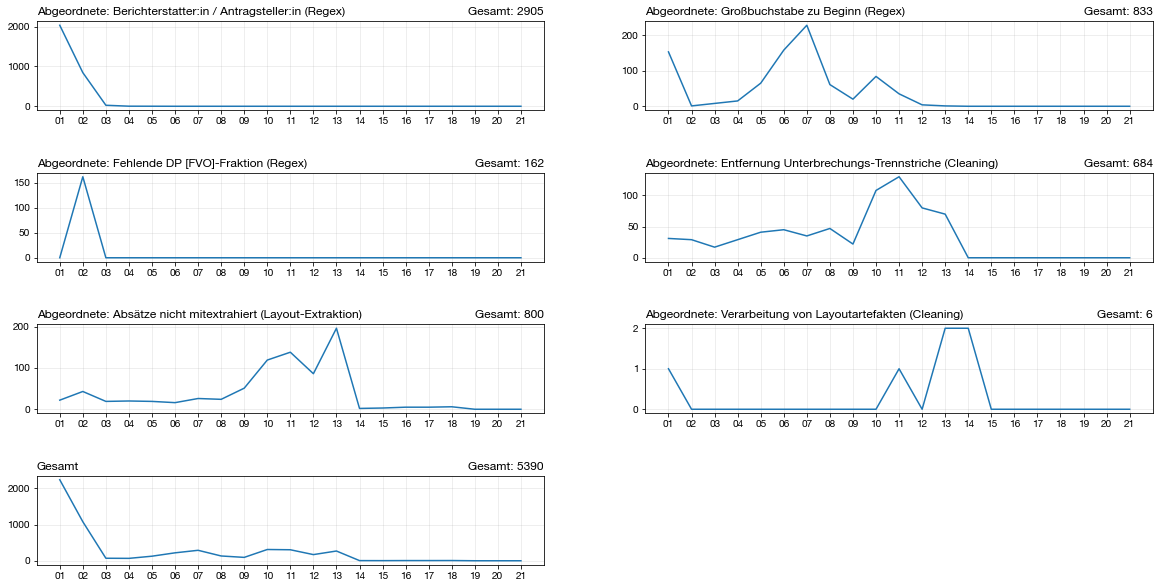

In [15]:
plot_missing([8,9,10,11,12,14], matrix=[4,2], size=[20,10], summary = True)

**Absolute Zahl fehlender Redebeiträge von Abgeordneten im Gesamtkorpus nach Fehlerursache im Zeitverlauf.**

In [16]:
(5390 / len(dataset_open_discourse[dataset_open_discourse.positionShort == "Member of Parliament"])) / (41 / len(data_gold[data_gold.position_group == "Abgeordnete:r"]))

1.0038003565494633

Der Vergleich des relativen Fehleranteils in der Stichprobe mit der RegEx-Muster-Zählung im Gesamtkorpus zeigt, dass die RegEx-Muster die vorhandenen Fehler vollständig zu erklären scheinen. Da jedoch mehrere Problemfelder (z. B. OCR) hier gar nicht abgebildet sind, ist es möglich, dass die verwendeten Muster etwas zu viele Fehler erkennen, oder aber in der Stichprobe Fehler überrepräsentiert waren.

In jedem Fall zeigt sich wieder ein zeitlicher Schwerpunkt: In Periode 1 liegen über 2000 fehlende Redebeiträge vor, analog zu der Berechnung im vorherigen Kapitel sind das schätzungsweise 20 % fehlende Redebeiträge für Abgeordnete. In der 2. Periode immer noch 10 %, in Periode 12 dagegen nur rund 1 %. Ab der 14. Periode gibt es nahezu keine fehlenden Redebeiträge mehr für diese Gruppe.

In [19]:
missing = sum(table_missing_regex[table_missing_regex.position_group == "Abgeordnete"]["01"])
op = len(dataset_open_discourse[dataset_open_discourse.electoralTerm == 1])
print(str(round(missing / ((missing + op) * 0.38)*100, 1)), "%")

18.9 %


#### 3.5.1.4 Sitzungsleitung
Der Anteil der Redebeiträge der Sitzungsleitung hat mit 41.49 % den größten Einzelanteil am Gesamtkorpus, gleichzeitig hat es mit 0,89 % und 28 Beobachtungen die geringste Zahl an Fehlbeobachtungen in der Stichprobe.

In [20]:
check = pd.DataFrame(data_gold[(data_gold.in_op_dataset == False) & (data_gold.position_group == "Sitzungsvorstand")][["period","protocol_number", "speech_name_data", "text"]].copy())
check.text = check.text.str[:150]

display(HTML("<div style='height: 300px; overflow-y: scroll;'>"+check.to_html()+"</div>"))

,period,protocol_number,speech_name_data,text
1461,14,145,Vizepräsident Dr. Hermann Otto Solms:,"Guten\nTag, liebe Kolleginnen und Kollegen! Die Sitzung ist\neröffnet.\nIch rufe den Tagesordnungspunkt 1 auf:\nBefragung der Bundesregierung\n\nDie Bundesr"
1800,14,150,Präsident Wolfgang Thierse:,"Guten Morgen, liebe\nKolleginnen und Kollegen! Die Sitzung ist eröffnet.\n\nNach einer interfraktionellen Vereinbarung soll die heu-\ntige Tagesordnung um"
3904,10,213,Vizepräsident Frau Renger:,Das Wort hat der Abgeordnete Link.
4050,9,126,Vizepräsident Dr. h. c. Leber:,"Herr Abgeordneter Walther, erlauben Sie eine Zwischenfrage des Herrn Abgeordneten Heyenn?"
4257,9,14,Vizepräsident Wurbs:,Das Wort hat der Herr Parlamentarische Staatssekretär Engholm.
5398,7,140,Präsident 'Frau Renger:,"Zusatzfrage, Herr Abgeordneter."
5427,7,140,Präsident 'Frau Renger:,Keine weiteren Zusatzfragen.\nIch rufe die Frage 54 des Herrn Abgeordneten Eigen auf:\nWie steht die Bundesregierung zu Äußerungen des Bundesernährungsm
5440,7,140,Präsident 'Frau Renger:,Keine weitere Zusatzfrage.\nIch rufe die Frage 71 des Herrn Abgeordneten Gansel auf:\nWie beurteilt die Bundesregierung den Wahrheitsgehalt und die auße
5451,7,140,Präsident Frau Renger:,Herr Staatssekretär?
5499,7,140,Präsident Frau Renger:,Zweite Zusatzfrage.


Der häufigste Fehler ist dabei wieder die Nichtmöglichkeit eines kleinen Anfangsbuchstabens, das betrifft in dieser Stichprobe Kai-Uwe von Hassel (Präsident in Periode 6, Vizepräsident in Periode 5 und 7). Nicht in der Stichprobe enthalten, aber ebenfalls betroffen ist Richard von Weizsäcker (Vizepräsident des Bundestags in Periode 8 und 9). Während dies hier 12 fehlende Redebeiträge verursacht, ergibt eine einfache Zählung in den Rohdaten, dass wahrscheinlich rund 10.000 Redebeiträge, die von Hassel gemacht hat, fehlen (mit dem Muster: `(Vizep|P)räsident von Hassel:`):
> Präsident von Hassel: ([06185](https://dserver.bundestag.de/btp/06/06185.pdf))

Ein weiteres Problem ist die Nichterkennung wegen OCR-Fehler in Kombination mit den engen RegEx-Mustern, neun Beobachtungen in der Stichprobe, z.B.:
> President Dr. Ehlers: ([01229](https://dserver.bundestag.de/btp/01/01229.pdf))

> Vizeprasident Dr. Schäfer: ([01229](https://dserver.bundestag.de/btp/01/01229.pdf))

> Vizeprdsident Dr. Schmid: ([02087](https://dserver.bundestag.de/btp/02/02087.pdf))

> Vizepräsident Dr. Dehler. ([04184](https://dserver.bundestag.de/btp/04/04184.pdf))

> Präsident 'Frau Renger: (3x in [07140](https://dserver.bundestag.de/btp/07/07140.pdf))

> Präsident ,FrauRenger: ([07140](https://dserver.bundestag.de/btp/07/07140.pdf))

> Fräsident Frau Renger: ([07140](https://dserver.bundestag.de/btp/07/07140.pdf))


Die Nichterkennung wegen Tippfehler(n) im Wort (Vize-)Präsident führt zu drei Beobachtungen:
> Vizeräsident Dr. Dehler: ([04184](https://dserver.bundestag.de/btp/04/04184.pdf))

> Vizepräsidennt Frau Dr. Probst: ([05101](https://dserver.bundestag.de/btp/05/05101.pdf))

> Vizpräsident Frau Renger: Das Wort hat der Abgeordnete Link. ([10213](https://dserver.bundestag.de/btp/10/10213.pdf))


Die Anmerkung von Applaus direkt in der Namenszeile führt zu einer Beobachtung:
> Präsident D. Dr. Gerstenmaier (mit Beifall begrüßt) : ([03103](https://dserver.bundestag.de/btp/03/03103.pdf))

Analog zu den beiden Bundesregierungsreden fehlt in den Protokollen 14145](https://dserver.bundestag.de/btp/14/14145.pdf) und [14150](https://dserver.bundestag.de/btp/14/14150.pdf) der Eröffnungsredebeitrag durch den jeweiligen (Vize-)Präsidenten. Bei einem fehlenden Redebeitrag bleibt der Grund ungeklärt: 

> Vizepräsident Wurbs ([09014](https://dserver.bundestag.de/btp/09/09014.pdf))

Beachtenswert ist an dieser Stelle auch, dass das Problem der entfernten Worttrennstrich-Zeilenumbruch-Kombination hier nicht auftritt. Diese verhindert eigentlich die Erkennung einiger Abgeordneten-Reden durch das RegEx-Muster, das einen Zeilenumbruch am Beginn benötigt. Das dies nicht auftritt liegt daran, dass die Namen in diesem spezifischen Erkennungsmuster nicht am Beginn der Zeile stehen müssen. Dies ist wahrscheinlich als Workaround für ein Problem entstanden, da die Sitzungsleitung häufig Redebeiträge unterbricht, was zu solchen Gedankenstrichen am Zeilenende des vorherigen Redebeitrags führt. Dies wird dadurch problematisch, da in dieser Regel neben dem:der (Vize-)Präsident:in, Alterspräsident:in und Bundespräsident:in auch der:die Bundeskanzler:in als Matchgruppe möglich ist. Dies führt zu den Zwischenrufen die fälschlich als Redebeiträge erkannt werden und die unterbrochenen Reden zerschneiden.

Mithilfe von RegEx-Mustern können die Fehlergruppen wieder im Gesamtkorpus gezählt und visualisiert werden:

In [21]:
regex_pattern_sitzungsleitung = {18: r"(Vizep|P)räsident von (Hassel|Weizsäcker) ?:",
                                 19: r"(?!Alterspräsident(in)?|Präsident(in)?|Vizepräsident(in)?)(Vize?p|P|F).{1,2}sidenn?t.{5,30}? ?:|^(Alterspräsident(in)?|Präsident(in)?|Vizepräsident(in)?)[^:]{0,20}['\",][^:]{0,25}:",
                                 20: r"^(Alterspräsident(in)?|Präsident(in)?|Vizepräsident(in)?)(?! des)[^\d\n:]*?\) ?:"}
count_missing_speeches(regex_pattern_sitzungsleitung)

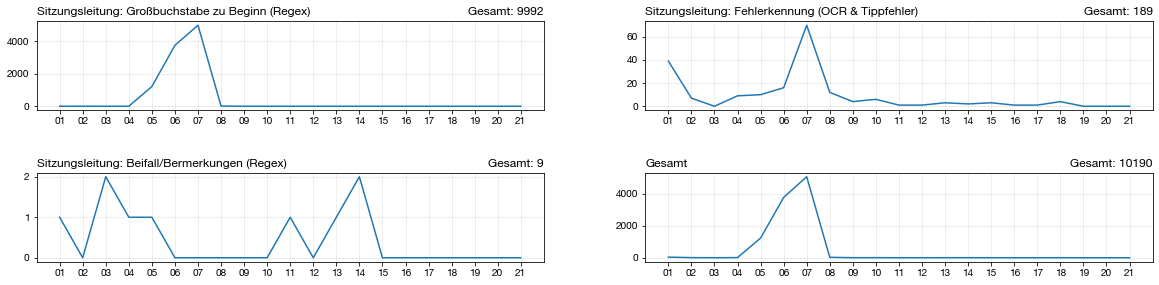

In [22]:
plot_missing([18,19,20], matrix=[4,2], size=[20,10], summary = True)

**Abbildung 8: Absolute Zahl fehlender Redebeiträge der Sitzungsleitung im Gesamtkorpus nach Fehlerursache im Zeitverlauf.**

In [23]:
missing = sum(table_missing_regex[table_missing_regex.position_group == "Sitzungsleitung"]["07"])
op = len(dataset_open_discourse[dataset_open_discourse.electoralTerm == 7])
print(str(round(missing / ((missing + op) * 0.41)*100, 1)), "%")

19.8 %


Die fehlenden Redebeiträge für die Sitzungsleitung im Gesamtkorpus zeigen analog zu der Stichprobe zwar relativ gesehen nur einen geringen Anteil fehlender Redebeiträge über den gesamten Zeitraum der 18 Perioden, absolut sind es jedoch schätzungsweise 10.200 Redebeiträge die fehlen. Dies ist hauptsächlich zurückzuführen auf die Nichtbeachtung der Nachnamen mit Kleinbuchstaben zu Beginn. Für die Periode 7 fehlen dabei schätzungsweise 20 % der Redebeiträge der Sitzungsleitung.

#### 3.5.1.5 Überblick
Mehr als 25 Fehler wurden identifiziert, von diesen konnten 20 mithilfe von RegEx-Mustern auch für das Gesamtkorpus und nicht nur die Stichprobe gezählt werden. Im Folgenden werden davon die fünf gravierendsten Fehler in ihrem Zeitverlauf dargestellt und in Relation zueinander und der Summe der restlichen Fehler gesetzt:

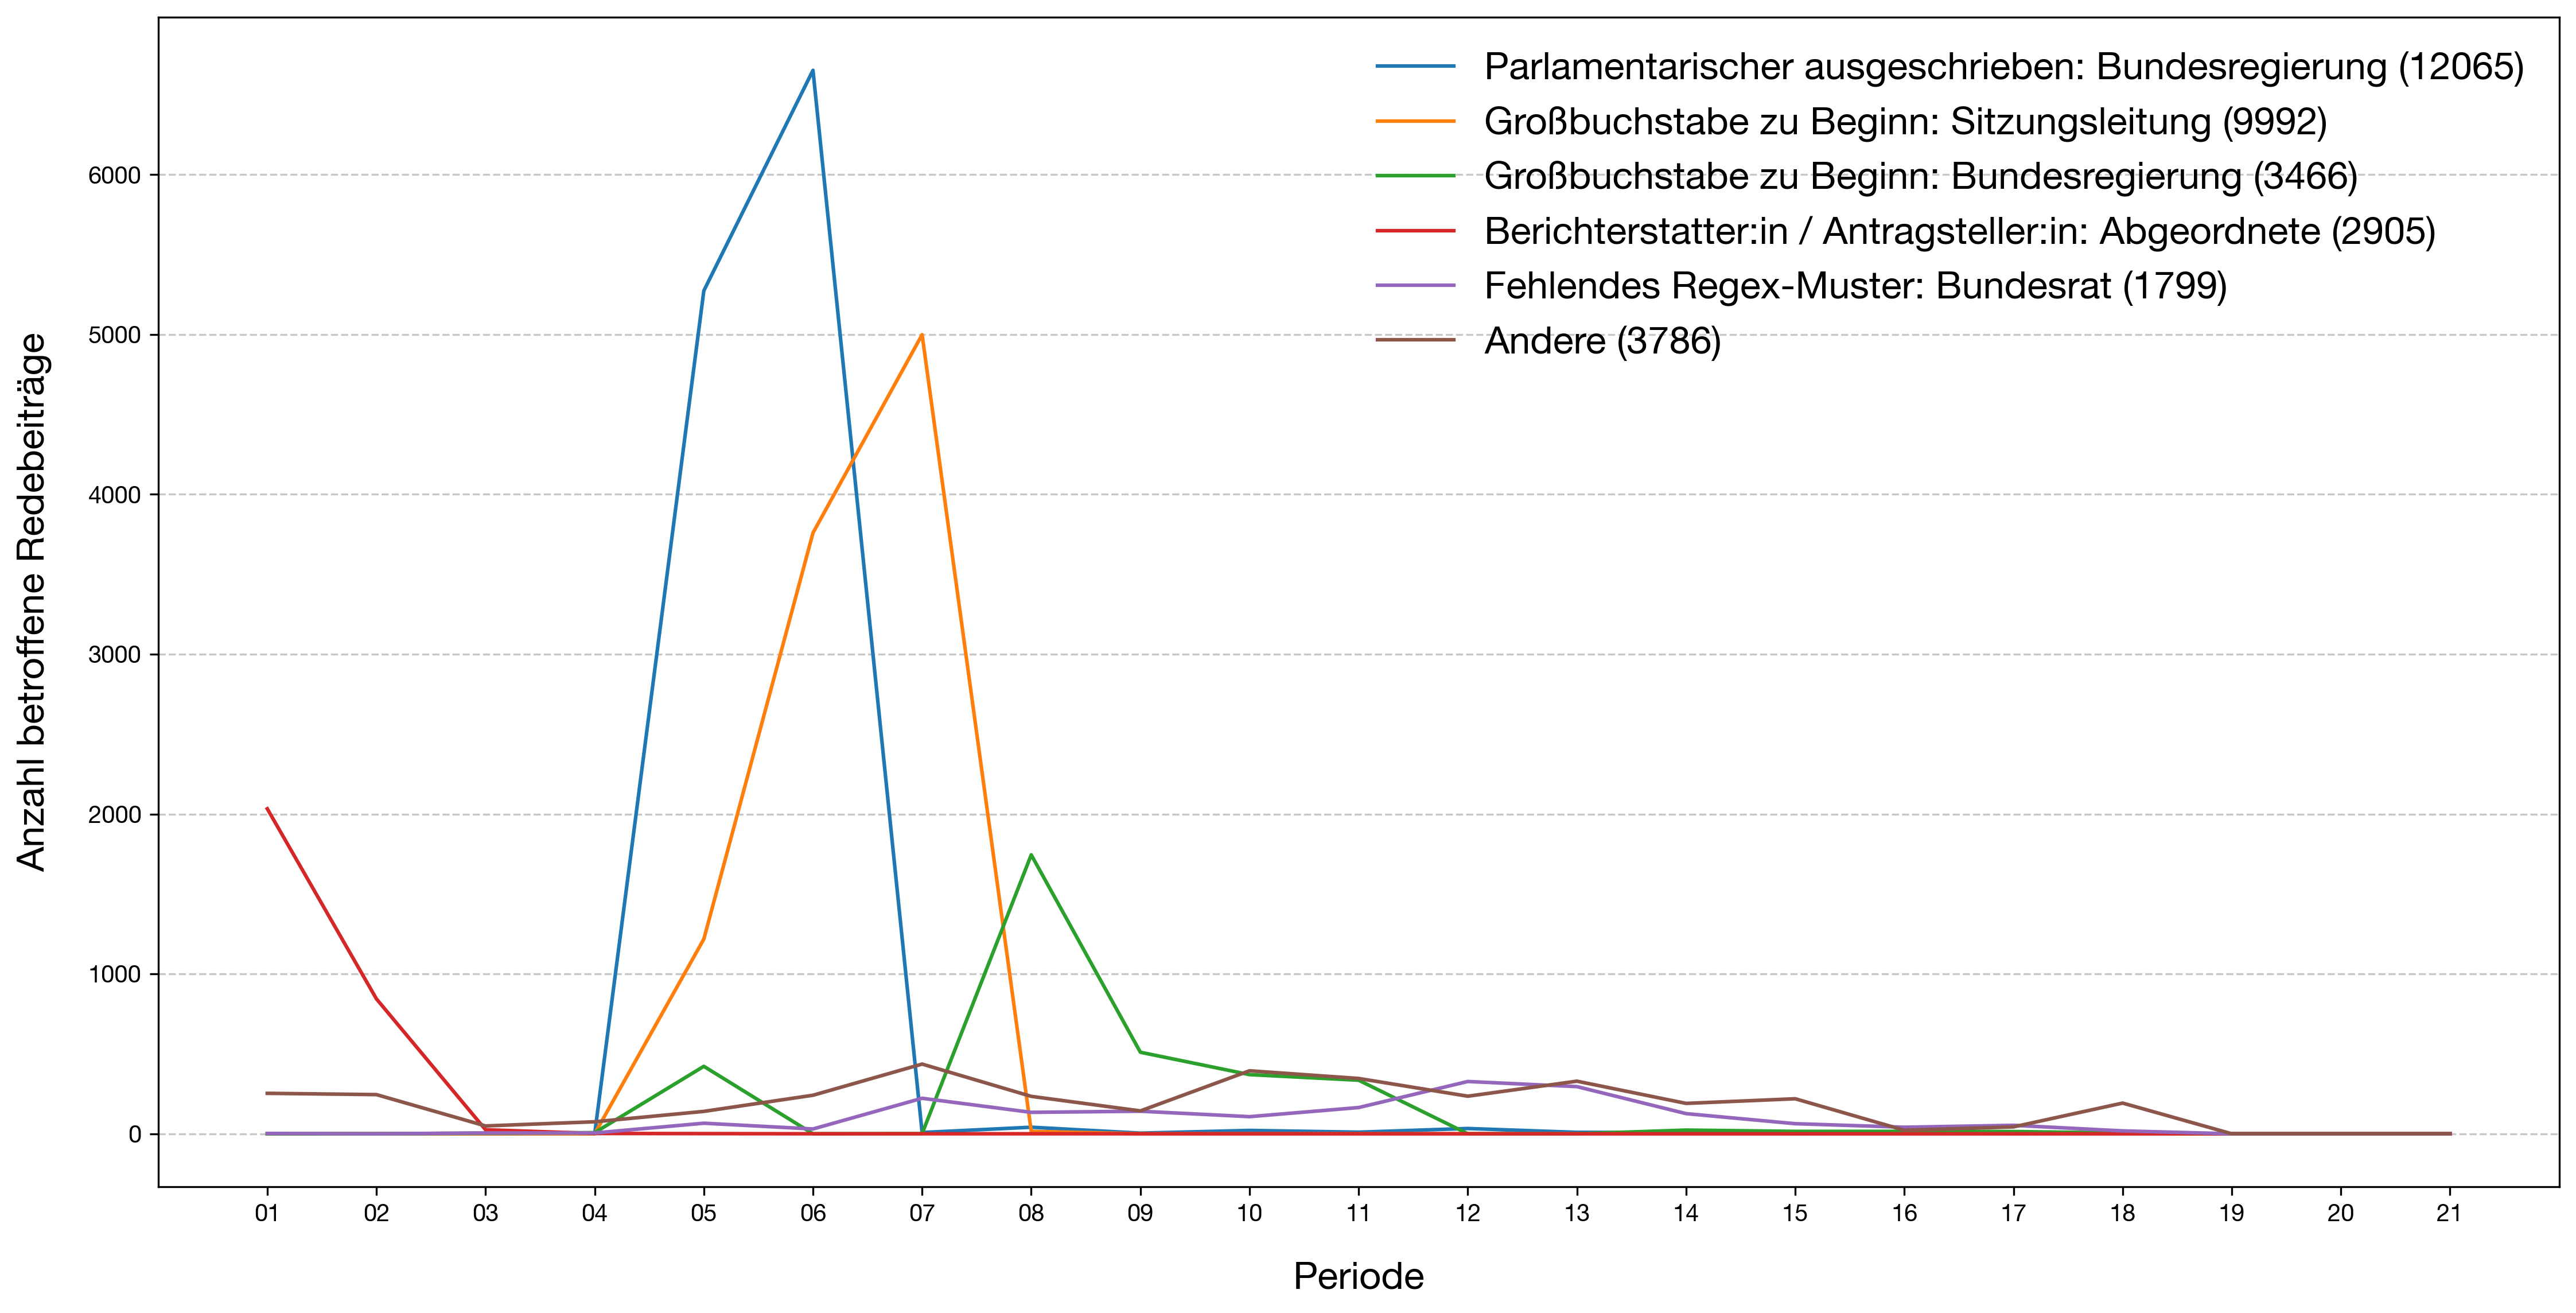

In [24]:
# Font
mpl.rc('font', family='Helvetica Neue')

plot_missing_regex = table_missing_regex[['position_group', 'description'] + [f"{i:02}" for i in range(1, 22)]].copy()
plot_missing_regex['text'] = plot_missing_regex['description'] + ": " + plot_missing_regex['position_group']
plot_missing_regex = plot_missing_regex[['text'] + [f"{i:02}" for i in range(1, 22)]].copy()

# Berechne die Summe je Kategorie
plot_missing_regex['total'] = plot_missing_regex[[f"{i:02}" for i in range(1, 22)]].sum(axis=1)

# Filter nach den Top 5
top_5_categories = plot_missing_regex.nlargest(5, 'total')

# Transponieren und Spalte Text als Index setzen
top_5_categories = top_5_categories.set_index('text')[[f"{i:02}" for i in range(1, 22)]].T

# Berechnung der Rest-Entwicklung
remaining_categories = plot_missing_regex[~plot_missing_regex.text.isin(top_5_categories.columns)]
remaining_sum = remaining_categories[[f"{i:02}" for i in range(1, 22)]].sum(axis=0).T
remaining_sum.index = [f"{i:02}" for i in range(1, 22)]

# Kombinieren der Top-5- und Rest-Kategorien
plot_data = pd.concat([top_5_categories, remaining_sum.to_frame('Andere')], axis=1)

# Mit hoher Auflösung ploten
fig, ax = plt.subplots(figsize=[18, 9], dpi=300)
plot_data.plot(ax=ax)

# Zeige alle Perioden-Label
ax.set_xticks(range(len(plot_data.index)))
ax.set_xticklabels(plot_data.index)

# Plot-Einstellungen
ax.set_xlabel("Periode", fontsize=16, labelpad=15)
ax.set_ylabel("Anzahl betroffene Redebeiträge", fontsize=16, labelpad=15)
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal gridlines with 70% opacity

# Legende mit Anzahl
ax.legend([f"{text} ({total:.0f})" for text, total in zip(plot_data.columns, plot_data.sum())], fontsize=16, frameon=False, edgecolor='black')

# Plot-Anzeige
plt.show()

**Abbildung 9: Fehlende Redebeiträge der fünf gravierendsten identifizierten Fehlergruppen im Zeitverlauf.**

Der Graph zeigt deutlich, dass es einige wenige Fehler gibt, die einen massiven Einfluss auf die Zahl fehlender Redebeiträge haben. Allein, dass das entsprechende OP-Muster „Parlamentarischer“ nicht enthält und somit „Parlamentarischer Staatssekretär“ nicht erkennt, führt dazu, dass über 12.000 Redebeiträge nicht erkannt wurden. Dies ist dicht davon gefolgt, dass für die Sitzungsleitung erwartet wurde, dass der Nachname mit einem Großbuchstaben beginnt, was zu fast 10.000 fehlenden Redebeiträgen von Bundestagspräsidenten von Hase führte. Der gleiche Fehler betrifft auch die Bundesregierung mit rund 3.500 fehlenden Redebeiträgen. Zudem zeigt sich ein starker zeitlicher Fehler-Cluster in den Perioden 5, 6 und 7, danach kommt es zu einer Abnahme der Fehlerzahlen.

### 3.5.2 Fehlerhafter Umfang
Der Grund für den Großteil der Redebeiträge mit fehlerhaftem Umfang war die Nichterkennung des jeweils folgenden Redebeitrags, da dessen Textinhalts der vorherigen Rede angehängt wurde. Somit führen alle der eben beschriebenen fehlenden Redebeiträge dazu, dass die jeweils vorherige Rede ebenfalls fehlerhaft ist. Weiterhin führen Zwischenrufe innerhalb des Redebeitrages, die fälschlich als Redebeitrag erkannt werden, zu verkürzten Redebeitragsumfängen.

Zusätzlich gäbe es auch die Möglichkeit, dass bei der Textbereinigung neben den eigentlich zu bereinigenden Stellen (z. B. Kopfzeilen, Layoutartefakte) und der Extraktion von Zwischenrufen eigentlicher Redetext verloren gegangen ist. Dies ist oberflächlich nicht zu erkennen, aber nicht auszuschließen.

Welche der beiden Fehlerquellen vorliegt, fehlerkannter Zwischenruf oder fehlende Folgerede, lässt sich in der Stichprobe nachzählen. Ersteres auf Basis der Differenz des OP-ID-Zählers des zu untersuchenden Redebeitrags und des nächsten richtig erkannten Redebeitrags: Wenn diese größer als eins ist, liegt dazwischen mindestens ein falsch erkannter Redebeitrag (so hat Helmut Kohl in seinen Zwischenrufen oft mehrmals die gleichen Redebeiträge unterbrochen). Ein Umfangsfehler wegen einer nicht erkannten Folgerede lässt sich daran erkennen, wenn eben jener folgende Redebeitrag im OP-Korpus fehlt.

Diese Zählung wird mit folgenden Code automatisiert durchgeführt und zusätzlich auf die verschiedenen vertretenen Sprecher:innen-Gruppen aufgeteilt. Theoretisch könnte nur die Sitzungsleitung von fehlenden Folgereden betroffen sein, da sie als Moderation in der Regel die Redner:innen aufruft. Dies ist zwar nicht per se weniger problematisch, ließe aber das Problem eingrenzen:

In [25]:
table_scope_position_group = pd.DataFrame()
for position_group_title in data_gold[data_gold.position_group != ""].position_group.unique():
    # Gesamtzahl je Gruppe
    position_group = data_gold[data_gold.position_group == position_group_title]
    count_position_group = len(position_group)
    
    # Beitragsumfang
    scope_per_position_group = len(position_group[position_group.correct_scope == False])
    
    # Grund für fehlerhaften Beitragsumfang
    count_missing = 0
    count_mistaken = 0
    count_unclear = 0
    
    # Iteriere über alle Reden mit fehlerhaften Umfang in der Positionsgruppe
    for i, speech in position_group[position_group.correct_scope == False].iterrows():
        # Prüfe ob es eine direkte Folgerede im Goldstandard-Korpus gibt
        if(len(data_gold[data_gold.id == speech.id + 1]) > 0):
            next_speech = data_gold[data_gold.id == speech.id + 1].iloc[0]
            # Wenn die Folgerede nicht im OP-Dataset ist, zähle es als fehlende Rede
            if not next_speech.in_op_dataset:
                count_missing += 1
            elif next_speech.id_count_difference > 1 and next_speech.id_count_difference < 10:
                count_mistaken += 1
            else:
                print(speech.id, speech.op_fuzz_end, speech.difference_length)
                count_unclear += 1
        # Falls es keine Folgerede gibt, also der Redebeitrag am Ende des Protokolls steht
        else:
            print(speech.id, speech.op_fuzz_end, speech.difference_length)   
            count_unclear += 1
    
    # Zusammenfügen
    scope_position_group = pd.DataFrame({'Gruppe':[position_group_title],
                                           'Fehlhafter Beitragsumfang':[scope_per_position_group],
                                           'Fehlende Folgerede':[count_missing],
                                           'Fälschlich abgeschnitten':[count_mistaken],
                                           'Unklar':[count_unclear]})
    table_scope_position_group = pd.concat([table_scope_position_group, scope_position_group], ignore_index=True)

table_scope_position_group

8025387 38.0 0.4285232067510549


,Gruppe,Fehlhafter Beitragsumfang,Fehlende Folgerede,Fälschlich abgeschnitten,Unklar
0,Sitzungsvorstand,111,106,4,1
1,Bundesregierung,9,9,0,0
2,Abgeordnete:r,126,113,13,0
3,Bundesrat,0,0,0,0


Es zeigt sich, dass die Probleme der fehlenden Folgerede auf die verschiedenen Gruppen verteilt sind und jeweils über 90 % der Redebeiträge mit Umfangsfehlern beschreiben. Beide Fehler sind dabei hochproblematisch, da sie den betroffenen Politiker:innen in automatisierten Untersuchungen Worte in den Mund legen, die sie nicht gesagt haben. Das trifft zu im Fall der fehlenden Folgerede, weil der aktuelle Redebeitrag den Textinhalt der Folgerede beinhaltet sowie im Fall des fehlererkannten Zwischenrufs, weil der Rest des durch den Zwischenrufs unterbrochenen Redebeitrags dem:der Zwischenrufer:in zugeordnet wird. Daneben sind die abgeschnittene Redebeiträge selbst auch noch problematisch, da ein Teil ihres Inhalts fehlt.

### 3.5.3 Zuordnungsfehler
#### 3.5.3.1 Abgeordnete
In der Stichprobe gibt es bei den Redebeiträgen von Abgeordneten 20 Zuordnungsfehler, diese können durch die im vorherigen Kapitel eingeführten ID-Matching-Codes hinsichtlich ihrer Gründe untersucht werden: 

In [26]:
table_id_eval_bundesregierung = pd.DataFrame()
for id_eval in data_gold[data_gold.position_group == "Abgeordnete:r"].id_eval.unique():
    position_group = data_gold[data_gold.position_group == "Abgeordnete:r"]
    
    count_id_eval = len(position_group[position_group.id_eval == id_eval])
    rel_count_id_eval = str(round(count_id_eval / len(position_group)*100, 2)) + " %"
    
    id_eval_val = pd.DataFrame({'Ergebnis':[id_eval],'Anzahl':[count_id_eval], 'Relativer Anteil': [rel_count_id_eval]})
    table_id_eval_bundesregierung = pd.concat([table_id_eval_bundesregierung, id_eval_val], ignore_index=True)
table_id_eval_bundesregierung

,Ergebnis,Anzahl,Relativer Anteil
0,true_positive_match_match,2795,97.83 %
1,false_negative_none_match,20,0.7 %
2,,42,1.47 %


Für die Abgeordneten gibt es in der Stichprobe als ID-Fehler – ausgenommen vollständig fehlende Redebeiträge – nur fehlende Zuordnungen, jedoch keine Zuordnungen zu falschen Personen. Die entsprechenden Redebeiträge sind im Folgenden ausgeben:

In [27]:
speeches_mdb_false_id_ids = data_gold[(data_gold.id_eval == 'false_negative_none_match')& (data_gold.position_group == "Abgeordnete:r")].op_id
speeches_mdb_false_id_op = data_op[data_op.id.isin(speeches_mdb_false_id_ids)].drop(columns=['speechContent'])
display(HTML("<div style='height: 240px; overflow:scroll-y'>"+speeches_mdb_false_id_op.to_html()+"</div>"))

,id,session,electoralTerm,firstName,lastName,politicianId,factionId,documentUrl,positionShort,positionLong,date,in_gold_dataset
1116,706039,133,16,Silke Stokar,Neuforn,-1,3,https://dip21.bundestag.de/dip21/btp/16/16133.pdf,Member of Parliament,None,2007-12-13,True
1154,706077,133,16,Silke Stokar,Neuforn,-1,3,https://dip21.bundestag.de/dip21/btp/16/16133.pdf,Member of Parliament,None,2007-12-13,True
1161,706084,133,16,Silke Stokar,Neuforn,-1,3,https://dip21.bundestag.de/dip21/btp/16/16133.pdf,Member of Parliament,None,2007-12-13,True
1416,651283,58,15,Silke Stokar,Neuforn,-1,3,https://dip21.bundestag.de/dip21/btp/15/15058.pdf,Member of Parliament,None,2003-09-09,True
2432,507315,152,12,Gernot,Eder,-1,23,https://dip21.bundestag.de/dip21/btp/12/12152.pdf,Member of Parliament,None,1993-04-22,True
2443,507326,152,12,Gernot,Eder,-1,23,https://dip21.bundestag.de/dip21/btp/12/12152.pdf,Member of Parliament,None,1993-04-22,True
2493,507376,152,12,Petra,Bläss,-1,22,https://dip21.bundestag.de/dip21/btp/12/12152.pdf,Member of Parliament,None,1993-04-22,True
2495,507378,152,12,Petra,Bläss,-1,22,https://dip21.bundestag.de/dip21/btp/12/12152.pdf,Member of Parliament,None,1993-04-22,True
2497,507380,152,12,Petra,Bläss,-1,22,https://dip21.bundestag.de/dip21/btp/12/12152.pdf,Member of Parliament,None,1993-04-22,True
3981,345139,126,9,Spies,Büllesheim,-1,4,https://dip21.bundestag.de/dip21/btp/09/09126.pdf,Member of Parliament,None,1982-11-10,True


In [28]:
data_gold[(data_gold.id_eval == 'false_negative_none_match') & (data_gold.position_group == "Abgeordnete:r")].full_name.unique()

array(['Silke Stokar von Neuforn', 'Gernot Erler',
       'Petra Bläss-Rafajlovski', 'Adolf Freiherr Spies von Büllesheim',
       'Richard Stücklen', 'Wilderich Freiherr Ostman von der Leye',
       'Thomas Ruf', 'Friedrich Kühn', 'Helene Weber'], dtype=object)

Von den neun Politiker:innen, auf die sich die fehlenden Zuordnungen verteilen, handelt es sich bei drei Personen um Namen, die auf ehemalige Adelsgeschlechter verweisen: Silke Stokar von Neuforn, Adolf Freiherr Spies von Büllesheim, Wilderich Freiherr Ostman von der Leye. Diese drei Personen verantworten neun Redebeiträge, verglichen mit 16 Redebeiträgen von Vertreter:innen ehemaliger Adelsgeschlechter in der OP-Korpus-Stichprobe, die tatsächlich erkannt wurden:

In [29]:
# Redebeiträge von Abgeordneten aus ehemaligen Adelsfamilien
politicians_open_discourse = pd.read_feather("../data/open_discourse/politicians.feather")
len(data_op[data_op.politicianId.isin(politicians_open_discourse[~politicians_open_discourse.aristocracy.isnull()].id.unique())])

16

Neun Redebeiträge wurden also nicht erkannt, 16 dagegen schon. Aus dieser kleinen Zahl von Beobachtungen von Redebeiträgen lässt sich kaum verlässlich ermitteln, welcher Anteil von Redebeiträgen von Menschen, die in der Politiker:innen-Tabelle des OP-Korpus und den Stammdaten des Bundestags als adelig getaggt sind, fehlt. Es ist jedoch offensichtlich, dass jede Untersuchung, die sich mit einer Fragestellung rund um ehemalige Adelsgeschlechter im Bundestag beschäftigt, hier keine verlässliche Datengrundlage findet.

Das eigentliche Problem liegt nicht in der Handhabung ehemaliger Adelstitel, sondern in der programmierten Fehlannahme, dass Nachnamen keine Leerzeichen enthalten können. Das Adelsprädikat von wurde gefiltert, außerdem wurden teilweise Titel wie Graf fälschlich als Vornamen erkannt, wodurch „Graf von Lambsdorff“ erkannt wurde, „Freiherr Ostman von der Leye“ jedoch nicht. Während dies hauptsächlich Abgeordnete aus ehemaligen Adelsgeschlechtern betrifft, gibt es auch einen anderen Abgeordneten, der nicht zugeordnet wurde: German Meneses Vogl (Stammdaten-ID: 11001468).[[8]](#ref_8) Das Problem betrifft insgesamt 21 Politiker:innen, deren Redebeiträge im OP-Korpus nicht gematched sind:

In [30]:
politicians_open_discourse[politicians_open_discourse.lastName.str.contains(" ")].lastName.unique()

array(['Fugger von Glött', 'Heereman von Zuydtwyck',
       'Henckel von Donnersmarck', 'Heydt Freiherr von Massenbach',
       'Martini zum Berge', 'Meneses Vogl', 'Meyer zu Bentrup',
       'Nöll von der Nahmer', 'Op den Orth', 'Ostman von der Leye',
       'Riederer von Paar', 'Schlichting von Rönn', 'von Schoeler',
       'Spies von Büllesheim', 'Stokar von Neuforn',
       'Marschall von Bieberstein', 'De Ridder', 'In der Beek',
       'Elsner von Gronow', 'De Masi', 'Mohamed Ali'], dtype=object)

 Die Handhabung der ehemaligen Adelstitel selbst hat auch ein Fehlerpotenzial im OP-Code, jedoch kommt dieses aufgrund des vorangegangen Leerzeichen-Fehlers nicht zum Tragen.[[9]](#ref_9)

Die weiteren 11 Redebeiträge lassen sich auf unterschiedliche Gründe zurückführen: Petra Bläss ist in den Bundestags-Stammdaten als Petra Bläss-Rafajlovski hinterlegt. In ihrer Rolle als Präsidentin wird dies im Code gesondert beachtet, für die Abgeordneten-Redebeiträge führt es zur Nichterkennung.[[10]](#ref_10)

Die Rede des „Herrn Rui“ ist eigentlich von Thomas Ruf, solche OCR-Fehler wurden durch eine Fuzzy-Ratio-Suche im OP-Code normalweise gut aufgefangen, bei nur drei Buchstaben, ist die Abweichung jedoch zu groß und führt zu dem niedrigen Fuzz-Score von 67. Dies trifft auch bei den beiden Redebeiträgen von Gernot Eder zu, der eigentlich Gernot Erler heißt – ebenfalls mit einem Fuzz-Score von 67.

Zusätzlich gibt es Anomalien, die einen tieferen Blick in den Code erfordern würden: Die Rede von Herrn „Stückten“, der eigentlich Richard Stücklen heißt, sollte mit einem Fuzz-Score von 88 matchen, da dies über dem OP-Code-Schwellenwert von 70 liegt. Auch die beiden Redebeiträge von Friedrich Kühn sollten eigentlich zugeordnet sein, hier fehlt weder der richtige Ortszusatz noch die Fraktion, mit der er von den beiden weiteren Abgeordneten mit dem Nachnamen „Kühn“ dieser Periode abgegrenzt werden könnte. Ein Redebeitrag von „Weber“ lässt sich Helene Weber zuordnen. Dies ist wahrscheinlich nicht geschehen, weil es zu diesem Zeitpunkt einen Karl Weber in der gleichen Periode gab. Dabei gibt es im OP-Code eigentlich eine Prüfung, um das Geschlecht bei dem Matching zu berücksichtigen.[[11]](#ref_11)

#### 3.5.3.2 Bundesregierung
Wie für die Abgeordneten können auch die Zuordnungsfehler innerhalb der Bundesregierung mit den ID-Matching-Codes auf ihre Häufigkeit untersucht werden:

In [31]:
table_id_eval_bundesregierung = pd.DataFrame()
for id_eval in data_gold[data_gold.position_group == "Bundesregierung"].id_eval.unique():
    position_group = data_gold[data_gold.position_group == "Bundesregierung"]
    
    count_id_eval = len(position_group[position_group.id_eval == id_eval])
    rel_count_id_eval = str(round(count_id_eval / len(position_group)*100, 2)) + " %"
    
    id_eval_val = pd.DataFrame({'Ergebnis':[id_eval],'Anzahl':[count_id_eval], 'Relativer Anteil': [rel_count_id_eval]})
    table_id_eval_bundesregierung = pd.concat([table_id_eval_bundesregierung, id_eval_val], ignore_index=True)
table_id_eval_bundesregierung

,Ergebnis,Anzahl,Relativer Anteil
0,true_positive_match_match,1059,68.68 %
1,,151,9.79 %
2,false_negative_none_match,227,14.72 %
3,true_negative_none_none,104,6.74 %
4,false_positive_match_match,1,0.06 %


Von insgesamt 228 fehlerhaften ID-Zuordnungen lassen sich 227 Beobachtungen auf Nicht-Zuordnungen zurückführen. Nur eine Einzige (die einzige Fehlzuordnung in der gesamten Stichprobe) auf eine Zuordnung zu einer falschen Person.[[12]](#ref_12) 222 der fehlenden Zuordnung entfallen auf Staatssekretär:innen und -minister:innen, die zum Zeitpunkt der Rede Abgeordnete sind oder waren, etwas, das den normalen Modus für Staatssekretär:innen darstellt.[[13]](#ref_13) Fünf weitere entfallen auf den Bundesminister der Justiz, Karl Weber, für Reden von 1965.

In dem OP-Code bleibt der Begriff „Staatsminister“ für die Erkennung außen vor, der u. a. von Staatssekretär:innen im Auswärtigen Amt und im Bundeskanzleramt getragen wird:

In [32]:
goverment_id_fn = data_gold[(data_gold.position_group == "Bundesregierung") & (data_gold.id_eval == "false_negative_none_match")]
goverment_id_fn = goverment_id_fn[["id", "period","protocol_number", "speech_name_data", "text"]].copy()
print('Fehlende ID-Zuordnung von Staatsminister:innen:', len(goverment_id_fn[goverment_id_fn.speech_name_data.str.contains("Staatsminister")]))

Fehlende ID-Zuordnung von Staatsminister:innen: 126


In der Stichprobe sind 126, im gesamten OP-Korpus über 13.000 Redebeiträge davon betroffen.[[14]](#ref_14) Dies hat empfindliche Auswirkungen auf Untersuchungen hinsichtlich des Auswärtigen Amts wie auch des Bundeskanzleramts. Dies kann auch nicht einfach durch eine Filterung der Positionsspalte aufgefangen werden, da für den Großteil der Protokolle nur bei der ersten Nennung die volle Position ausgeschrieben wurde, z. B. „Moersch, Staatsminister im Auswärtigen Amt:“ ([07200](https://dserver.bundestag.de/btp/07/07200.pdf)), danach wurde jeweils nur die Kurzversion angegeben: „Moersch, Staatsminister“, was bei Fragerunden häufig mehrere Dutzend Redebeiträge betrifft.

Im OP-Code wird die Fehlannahme sichtbar, dass diejenigen Staatssekretär:innen, deren Titeln nicht „Parlamentarische“ vorangestellt ist, nur verbeamtete Staatssekretär:innen und keine Abgeordneten sein könnten, tatsächlich sind aber 21 hiervon in der Stichprobe enthalten.[[15]](#ref_15)

In [33]:
print('Staatssekretär:innen ohne vorangestelltes "Parl." oder "Parlamentatische":', 
      len(goverment_id_fn[(goverment_id_fn.speech_name_data.str.contains("Staatssekretär")) & 
                          (~goverment_id_fn.speech_name_data.str.contains("Parl"))]))

Staatssekretär:innen ohne vorangestelltes "Parl." oder "Parlamentatische": 21


Ein weiteres Problem, das zur fehlenden Zuordnung aufgrund mehrerer potenzieller Kandidat:innen  führte, war die eingeschränkte Nutzung von Attributen für die Zuordnung: In dem entsprechenden Matching-Code für Parlamentarische Staatssekretär:innen wurde geprüft, ob ein eindeutiges Politiker:innen-Match für die MdBs hergestellt werden kann, aber nur auf Basis des Nachnamens und der Periode:[[16]](#ref_16) In der folgenden Tabelle sind die Stichproben-Fälle aufgelistet, die dies betrifft:

Name         | Redebeiträge | Periode | Mögliche Matches 
-------------|--------------|---------|----------------------------------------------------------------------------
Dr. Schulte  | 16           | 11      | **Dr. Dieter Schulte (CDU)**, Brigitte Schulte (SPD)  
Wimmer       | 2            | 11      | **Willy Wimmer (Mönchengladbach) (CDU)**, Hermann Wimmer (SPD), Willy Wimmer (Neuss) (CDU)
Vogt         | 39           | 10      | **Wolfgang Vogt (CDU)**, Roland Vogt (Grüne)
Becker       | 10           | 2       | **Helmut Becker (SPD)**, Karl Becker (CDU)


Grundsätzlich könnte Dr. Schulte mit den vorhandenen Daten (Dr.-Titel, männlich) abgeglichen werden; der OP-Code nutzt den akademischen Titel jedoch nicht zur Filterung. Das Geschlecht wird nur einbezogen wenn ein „Frau“ vorangestellt ist, um Männer ausfiltern zu können, nicht aber andersherum. Für die weiteren drei Staatssekretäre wären Zusatzinformationen notwendig, beispielsweise durch eine Wikidata-Abfrage. Solche werden für Regierungsmitglieder eigentlich genutzt, für fünf Redebeiträge des Justizministers Karl Weber kommen diese jedoch nicht zum Tragen. Minister:innen werden zuerst mit einer Liste von Regierungsmitgliedern abgeglichen, es gab nur ein einziges Regierungsmitglied mit dem Namen Weber – ihn; weshalb dies also nicht funktionierte, bleibt zu prüfen. Dagegen gibt es fünf MdBs in der entsprechenden Periode, die Weber mit Nachnamen heißen.

Acht weitere fehlende Zuordnungen gibt es für Redebeiträge des Staatssekretärs von Schoeler. Diese wurden zwar als Redebeiträge erkannt, weil fälschlicherweise die vorherige Zeile als Vorname extrahiert wurde (Vorname: „Bitte Herr Staatssekretär“), konnten aber nicht gematched werden, weil das RegEx-Muster im Nachnamen das Präfix „von“ entfernte. Bei Andreas von Schoeler ist das in den Stammdaten jedoch nicht als Präfix, sondern als Teil des Nachnamens hinterlegt.

### 3.5.4 Fraktion
In den 36 untersuchten Protokollen findet sich nur eine einzige Fehlzuordnung der Fraktion:

In [34]:
data_gold[(data_gold.fraction_eval == False) & (data_gold.in_op_dataset == True)].head(50)

,id,period,protocol_number,speech_number,date,full_name,last_name,first_name,group,party,...,op_id,in_op_dataset,correct_scope,id_count_difference,id_eval,fraction_eval,postion_eval,difference_length,op_fuzz,op_fuzz_end
2279,12152029,12,152,29,1993-04-22,Klaus W. Lippold,Lippold,Klaus W.,CDU/CSU,CDU,...,507152,True,True,1,true_positive_match_match,False,,0.89136,100.0,99.0


Diese geht auf einen Fehler im Originaldokument zurück, wo Klaus W. Lippold fälschlich der SPD zugeordnet wurde.[[17]](#ref_17)

Hinsichtlich struktureller Missrepräsentation von Redebeiträgen der verschiedenen Fraktionen sei auf das Kapitel *3.5.4.1 Abgeordnete* verwiesen, in dem sich zeigt, dass für Kleinfraktionen und Gruppen aus der Bundestagsfrühzeit teils alle Redebeiträge fehlen: DP [FVP]: 162 Redebeiträge, DPB: 1 und BHE: 7 im Gesamtkorpus. 

In der Stichprobe sind die Fraktionen CDU/CSU, SPD und FDP zu ähnlich großen relativen Anteilen betroffen. Gleichzeitig gibt es für die Grünen und die Linke keine Fehlredebeiträge. Der Grund hierfür liegt mutmaßlich darin, dass zum Zeitpunkt des Einzugs der Grünen und der Linken sowie ihrer jeweiligen Vorgängerparteien/-fraktionen im Datensatz kaum mehr fehlende Redebeiträge von Abgeordneten vorkommen. Je nach Untersuchung kann dies das Bild tatsächlich verzerren.

In [35]:
groups_open_discourse = pd.read_feather("../data/open_discourse/factions.feather")
table_group_representation = pd.DataFrame()

for group_title in data_gold[data_gold.group != ""].group.unique():
    group = data_gold[data_gold.group == group_title]
    count_group = len(group)
    count_group_missing = len(group[~group.in_op_dataset])
    
    if count_group_missing > 0:
        count_group_missing_rel = count_group_missing/count_group
        party_representation = pd.DataFrame({'Gruppe':[group_title], 'Gesamtzahl':[count_group],
                                            'Fehlende Reden':[count_group_missing], 'Anteil fehlend':[count_group_missing_rel]})
        table_group_representation = pd.concat([table_group_representation, party_representation], ignore_index=True)

table_group_representation

,Gruppe,Gesamtzahl,Fehlende Reden,Anteil fehlend
0,CDU/CSU,1071,16,0.014939
1,SPD,957,17,0.017764
2,FDP,393,5,0.012723
3,fraktionslos,13,1,0.076923
4,DP,16,1,0.062500
5,DP/FVP,1,1,1.000000
6,GB/BHE,7,1,0.142857


### 3.5.5 Fälschlicherweise erkannte Reden

Für die 36 Protokolle finden sich 49 fälschlich als Redebeiträge erkannte Einträge im OP-Korpus, diese lassen sich einfach ausgeben:

In [36]:
wrongly_recognized_speeches = data_op[~data_op.in_gold_dataset].copy()
wrongly_recognized_speeches.speechContent = wrongly_recognized_speeches.speechContent.str[:50]
display(HTML("<div style='height: 300px; overflow-y: scroll;'>"+wrongly_recognized_speeches.to_html()+"</div>"))

,id,session,electoralTerm,firstName,lastName,politicianId,speechContent,factionId,documentUrl,positionShort,positionLong,date,in_gold_dataset
376,812481,88,18,Peter Hintze,Überweisungsvorschlag,-1,Ausschuss für Recht und Verbraucherschutz ({0})\nIn,-1,https://dip21.bundestag.de/dip21/btp/18/18088.pdf,Presidium of Parliament,vizepräsident,2015-02-26,False
410,812515,88,18,Claudia Roth Tagesordnungspunkt,b,-1,\nBeratung der Zweiten Beschlussempfehlung des\nWahl,-1,https://dip21.bundestag.de/dip21/btp/18/18088.pdf,Presidium of Parliament,vizepräsidentin,2015-02-26,False
469,812574,88,18,Petra Pau,Überweisungsvorschlag,-1,Ausschuss für Gesundheit ({0})\nAusschuss für Arbei,-1,https://dip21.bundestag.de/dip21/btp/18/18088.pdf,Presidium of Parliament,vizepräsidentin,2015-02-26,False
1025,705948,133,16,Katrin Göring-Eckardt Tagesordnungspunkt,f,-1,\nBeratung der Beschlussempfehlung und des Berichts,-1,https://dip21.bundestag.de/dip21/btp/16/16133.pdf,Presidium of Parliament,vizepräsidentin,2007-12-13,False
1026,705949,133,16,Katrin Göring-Eckardt Tagesordnungspunkt,o,-1,\nBeratung der Beschlussempfehlung des Petitionsaus,-1,https://dip21.bundestag.de/dip21/btp/16/16133.pdf,Presidium of Parliament,vizepräsidentin,2007-12-13,False
2141,479494,37,12,Helmut,Kohl,11001165,Darüber kann man nur lachen!)\ndie alten Parteikade,-1,https://dip21.bundestag.de/dip21/btp/12/12037.pdf,Chancellor,None,1991-09-04,False
2142,479495,37,12,Helmut,Kohl,11001165,"Das ist doch absurd!)\n- Herr Bundeskanzler, wenn S",-1,https://dip21.bundestag.de/dip21/btp/12/12037.pdf,Chancellor,None,1991-09-04,False
2152,479505,37,12,Helmut,Kohl,11001165,"Ja, selbstverständlich! - Dr. Hans-Jochen Vogel [S",-1,https://dip21.bundestag.de/dip21/btp/12/12037.pdf,Chancellor,None,1991-09-04,False
2153,479506,37,12,Helmut,Kohl,11001165,So war es doch! - Dr. Hans-Jochen Vogel [SPD]: Na!,-1,https://dip21.bundestag.de/dip21/btp/12/12037.pdf,Chancellor,None,1991-09-04,False
2154,479507,37,12,Helmut,Kohl,11001165,"Sehr gut!)\nIch finde es wirklich traurig, Herr Vog",-1,https://dip21.bundestag.de/dip21/btp/12/12037.pdf,Chancellor,None,1991-09-04,False


Daraus lassen sich fünf Gründe ableiten, die im Folgenden erörtert werden.

#### 3.5.5.1 Zwischenrufe
Ein großes Problem sind Zwischenrufe, die fälschlich als Redebeiträge erkannt werden, 15 der 48 Fehler lassen sich darauf zurückführen. In der Stichprobe betrifft dies insgesamt 15 Zwischenrufe von Helmut Kohl. Grund hierfür ist eine RegEx-Regel, die Redebeiträge der Sitzungspräsident:in und des:der Kanzler:in erkennen soll und keine Prüfheuristik für Zwischenrufe beinhaltet, dabei sind folgende Protokolle betroffen: 3x [09126](https://dserver.bundestag.de/btp/09/09126.pdf), 1x [11102](https://dserver.bundestag.de/btp/11/11102.pdf), 11x [12037](https://dserver.bundestag.de/btp/12/12037.pdf).

Dieses Problem führt dazu, dass im Gesamtkorpus fast 60 % der Redebeiträge Kohls eigentlich Zwischenrufe sind, der weitere Redetext gehört eigentlich der unterbrochenen Person und steht potenziell diametral zu Kohls Meinung. Für die anderen Kanzler:innen ist diese Thematik zwar ebenfalls vorhanden, aber weniger ausgeprägt.[[18]](#ref_18)

#### 3.5.5.2 Dubletten-Protokoll
Die Einträge für [01020](https://dserver.bundestag.de/btp/01/01020.pdf), die hier vertreten sind, gehören eigentlich zu Protokoll [01021](https://dserver.bundestag.de/btp/01/01021.pdf). Sie sind mit den gleichen Meta-Daten auch ein zweites Mal im OP-Korpus vertreten. Dies betrifft hier 20 Redebeiträge. Das Problem ist in der Stichprobe jedoch ein Ausreißer und überproportional vertreten. Mehr Informationen hierzu findet sich im 2. Kapitel in der Tabelle `minutes_duplicates_filtered`.

#### 3.5.5.3 Kopf-/Namenszeilen
Fünf Fehlerkennungen lassen sich auf Fehltrennungen von Sitzungsleitungsbeiträgen aufgrund der Kopfzeile zurückführen: Bei Redebeiträgen, die über mehrere Seiten reichen, wird auf der Druckseite oben rechts erneut der Name des:der Redner:in angegeben, ohne weitere Informationen oder Doppelpunkt. Wenn in der nächsten Zeile aus einem Redetext dann ein Doppelpunkt enthalten ist, führt dies zu einer Fehlerkennung.

In der Stichprobe sind nur Protokolle betroffen, die auf den born-digital PDFs basieren: Dreimal in [18088](https://dserver.bundestag.de/btp/18/18088.pdf), Zweimal in [16133](https://dserver.bundestag.de/btp/16/16133.pdf). Grundsätzlich tritt dies jedoch auch in früheren Perioden auf, z. B. im Protokoll 13015 (S. 932, Redebeitrags-OP-ID: 532080). Der Fehler liegt darin, dass in dem Prozess der Bereinigung der Dokumente von den Kopfzeilen im RegEx-Muster die Worte Präsident/Präsidentin und Vizepräsident/ Vizepräsidentin fehlen.[[19]](#ref_19)

Diese abgeschnittenen Redebeiträge können zudem nicht zugeordnet werden, da der extrahierte Nachname das letzte Wort vor dem Doppelpunkt in der Folgezeile ist, z. B. „Überweisungsvorschlag“ als Nachname ([18088](https://dserver.bundestag.de/btp/18/18088.pdf), Redebeitrags-OP-ID: 812481). Dadurch lassen sich auch einige – sicherlich nicht alle – Fehler im Gesamtkorpus identifizieren und zählen, mindestens 219 solcher Fälle gibt es.

In [37]:
headline_searches = ["Tagesordnungspunkt", "Überweisungsvorschlag", "Zusatzpunkt"]
falsely_speeches_headline = dataset_open_discourse[dataset_open_discourse.lastName.str.contains('|'.join(headline_searches)) | 
                                                   dataset_open_discourse.firstName.str.contains('|'.join(headline_searches))]
print(len(falsely_speeches_headline))

219


#### 3.5.5.4 Zitate
Vier der fälschlichen Erkennungen in der Stichprobe gehen auf Zitate innerhalb von Redebeiträgen zurück. Auch in diesem Fall ist wieder die RegEx-Regel, die falsche Zwischenrufs-Redebeiträge hervorbringt am Werk: Zitate von Kanzler:innen und Präsident:innen (auch z. B. Präsident Obama) führen zum Abschneiden des Redebeitrags ab der Zitatnennung, beispielsweise hier:

> [...] die Frage Num-<br/>
> mer eins im Zusammenhang mit den Aktivitäten von<br/>
Strauß und wohl auch von Bundeskanzler Kohl zum<br/>
Milliardenkredit lautet: Haben Strauß und andere<br/>
westdeutsche Politiker für ihre Vermittlungstätigkeit<br/>
Provision [...] ([12037](https://dserver.bundestag.de/btp/12/12037.pdf), S. 3069)

Hier wurde keine Zuordnung vorgenommen, der extrahierte Vorname in dem Datensatz ist „Kohl zum Milliardenkredit“, der Nachname „lautet“. Mit einer Liste von Worten, die Zitate häufig einleiten, lässt sich auch in diesem Fall eine Abschätzung der Gesamtzahl machen, mindestens 204 Redebeiträge im ganzen OP-Korpus sind betroffen.

In [38]:
quote_searches = ["erklärt", "sagt", "erzählt", "lautet", "äußer", "zitier", "sprach", "sproch", "eingestellt", "ausgeführt", " recht", "argumentiert", "erklärt", "bestätigt", "formuliert", "erinnert", "benannt", "schrieb"]
falsely_speeches_quote = dataset_open_discourse[dataset_open_discourse.lastName.str.contains('|'.join(quote_searches)) |
                                                dataset_open_discourse.firstName.str.contains('|'.join(quote_searches)) |
                                                dataset_open_discourse.positionLong.str.contains('|'.join(quote_searches))]
print(len(falsely_speeches_quote))

204


#### 3.5.5.5 Formfehler
Die verbleibenden zwei Redebeitrags-Fehlerkennungen gehen auf Formfehler in den Originaldokumenten zurück. Bei einem Redebeitrag von Kurt Georg Kiesinger wird nach dem Seitenwechsel eine erneute Vorstellungszeile eingefügt: „Kiesinger (CDU/CSU)“ ([03018](https://dserver.bundestag.de/btp/03/03018.pdf), S. 903). Bei einem Zwischenruf von Carl Otto Lenz fehlt die öffnende Klammer vor Beginn eines Zwischenrufs ([08025](https://dserver.bundestag.de/btp/08/08025.pdf), S. 1687).

### 3.5.6 Gender-Bias

Eine wichtige Frage ist, ob ein Gender-Bias bei der Erkennung und Zuordnung von Redebeiträgen vorliegt. Grundsätzlich ist der Bundestag nie paritätisch besetzt gewesen, von 6,8 % 1949 bis heute höchsten Stand nach Bundestagswahl 2013 mit 36,5 %. Für die Stichprobe lässt sich untersuchen, ob die Nicht-Erkennungen bzw. Nicht-Zuordnungen einen Gender-Bias aufweisen.

Hierfür wird erneut die MdB-Tabelle benötigt, die in Kapitel 3.3.1 erstellt wurde und auf Basis dessen die Redebeiträge ergänzt. Die Untersuchung betrachtet nur Bundestagsabgeordnete, Regierungsmitglieder dagegen, die kein Bundestagsmandat haben, sowie Bundesratsmitglieder bleiben dabei außen vor. Das entspricht dem Datenstand der Politiker:innen-Tabelle des OP-Korpus und Untersuchungen, die damit durchgeführt werden.

In [39]:
# MdB-Liste laden und ID-Gender-Tabelle erzeugen
mdbs = pd.read_feather("../data/evaluation/matching_data/mdbs.feather")
mdbs_gender = mdbs[['id', 'gender']].copy().drop_duplicates()
del mdbs

# Stichprobe durch Genderinformationen ergänzen
data_gold_gender = data_gold.copy()
data_gold_gender["gender"] = data_gold_gender["politician_id"].map(mdbs_gender.set_index('id')['gender'])

Mit der Funktion `gender_eval_overview()` lässt sich entsprechend die Verteilung zählen:

In [40]:
pd.options.display.float_format = '{:,.3f}'.format

def gender_eval_overview(data_gold_filtered):
    table_gender_representation = pd.DataFrame()
    for gender in ["männlich", "weiblich"]:
        gender_speeches = data_gold_filtered[data_gold_filtered.gender == gender]
        count = len(gender_speeches)
        rel = round(count / len(data_gold_filtered[data_gold_filtered.gender.isin(["männlich", "weiblich"])]), 3)
        count_missing = len(gender_speeches[~gender_speeches.in_op_dataset])
        count_non_assigned = len(gender_speeches[(gender_speeches.id_eval == 'false_negative_none_match') |
                                                 (gender_speeches.id_eval == 'false_positive_match_none') |
                                                 (gender_speeches.id_eval == 'false_positive_match_match')])
        count_op = count - count_missing - count_non_assigned
        # count_scope = len(gender_speeches[~gender_speeches.correct_scope])

        gender_representation = pd.DataFrame({'Gender':[gender], 
                                              'Gesamtzahl':[count],
                                              'Relativer Anteil': [rel],
                                              'Gesamtzahl OP*': [count_op],
                                              'Relativer Anteil OP*' : [0],
                                              'Fehlende Redebeiträge':[count_missing],
                                              'Fehlende Zuordnung': [count_non_assigned],
                                              'Fehlend & ohne Zuordnung':[count_missing+count_non_assigned],
                                              'Anteil fehlend & ohne Zuordnung':[(count_missing+count_non_assigned)/count]})
        table_gender_representation = pd.concat([table_gender_representation, gender_representation], ignore_index=True)
    
    
    table_gender_representation['Relativer Anteil OP*'] = table_gender_representation['Gesamtzahl OP*'] / sum(table_gender_representation['Gesamtzahl OP*'])
    display(table_gender_representation)
    print("* Ohne Fehlerkennungen")

In [41]:
gender_eval_overview(data_gold_gender)

,Gender,Gesamtzahl,Relativer Anteil,Gesamtzahl OP*,Relativer Anteil OP*,Fehlende Redebeiträge,Fehlende Zuordnung,Fehlend & ohne Zuordnung,Anteil fehlend & ohne Zuordnung
0,männlich,5529,0.747,5149,0.740,189,191,380,0.069
1,weiblich,1877,0.253,1807,0.260,13,57,70,0.037


* Ohne Fehlerkennungen


Der Anteil von fehlenden Redebeiträgen von Männern beträgt 6,8 %, für Frauen dagegen 3,7 %. Im Stichproben-OP-Korpus sind 74,1 % (mit fälschlichen Erkennungen von Zwischenrufen) der Redebeiträge von Männern, richtig sind dagegen 74,6 %. Für Frauen sind es entsprechend 25,9 % im OP-Korpus, tatsächlich dagegen 25,4 %.[[20]](#ref_20) Die Männer sind in dem Korpus also leicht unterrepräsentiert gegenüber ihrem realen Sprechanteil. Die Daten schönen leicht das Bild. 

Dabei ist festzuhalten, dass das Open-Discourse-Gesamtkorpus für die betrachteten Periode 1-18 einen Männeranteil bei den Redebeiträgen von 76,3 % hat, für Frauen 23,7 %.[[21]](#ref_21) Die Stichprobendaten ist also nicht 1:1 übertragbar, dennoch dürfte sich die Abweichung von dem realen Redeverhältnis auch im Gesamtkorpus spiegeln.

Ein Blick auf die Zahlen für Abgeordnete zeigt keinen signifikanten Unterschied und Gender-Bias:

In [42]:
gender_eval_overview(data_gold_gender[data_gold_gender.position_group == "Abgeordnete:r"])

,Gender,Gesamtzahl,Relativer Anteil,Gesamtzahl OP*,Relativer Anteil OP*,Fehlende Redebeiträge,Fehlende Zuordnung,Fehlend & ohne Zuordnung,Anteil fehlend & ohne Zuordnung
0,männlich,2354,0.824,2305,0.825,38,11,49,0.021
1,weiblich,503,0.176,490,0.175,4,9,13,0.026


* Ohne Fehlerkennungen


Die Zahlen für Vize-/Präsident:innen zeigen in der Stichprobe ebenfalls keinen signifikanten Gender-Bias aufgrund von Fehlern. Tatsächlich dürfte dieser jedoch vorhanden sein, da die systematischen Fehler hinsichtlich Nachnamen mit einem kleinen Vornamen zu rund 10.000 Nichterkennungen von Redebeiträgen des Präsidenten von Hassel führen, was rund 1 % fehlende Redebeiträge des Gesamtkorpus ausmacht.

In [43]:
gender_eval_overview(data_gold_gender[data_gold_gender.position_group == "Sitzungsvorstand"])

,Gender,Gesamtzahl,Relativer Anteil,Gesamtzahl OP*,Relativer Anteil OP*,Fehlende Redebeiträge,Fehlende Zuordnung,Fehlend & ohne Zuordnung,Anteil fehlend & ohne Zuordnung
0,männlich,1874,0.599,1852,0.597,22,0,22,0.012
1,weiblich,1257,0.401,1250,0.403,7,0,7,0.006


* Ohne Fehlerkennungen


Ein signifikanter Gender-Bias entsteht innerhalb der Stichprobe für die Bundesregierung: Die Erkennungsrate ist hier für Männer besser als für Frauen, somit sind Frauen darin weniger repräsentiert:

In [44]:
gender_eval_overview(data_gold_gender[data_gold_gender.position_group == "Bundesregierung"])

,Gender,Gesamtzahl,Relativer Anteil,Gesamtzahl OP*,Relativer Anteil OP*,Fehlende Redebeiträge,Fehlende Zuordnung,Fehlend & ohne Zuordnung,Anteil fehlend & ohne Zuordnung
0,männlich,1293,0.918,992,0.937,121,180,301,0.233
1,weiblich,115,0.082,67,0.063,0,48,48,0.417


* Ohne Fehlerkennungen


Die Fehlerkennungen und Zuordnungsschwächen für Vertreter:innen der Bundesregierung erklären über 75 % der Fehler. Bei den Stichproben-Daten ist jedoch zu beachten, dass die 48 fehlenden Zuordnungen auf zwei Frauen zurückgehen, beides Staatsministerinnen im Auswärtigen Amt: Dr. Hildegard Hamm-Brücher und Dr. Irmgard Schwaetzer. Dies muss nicht repräsentativ sein für den gesamten OP-Korpus, genauso plausibel wäre es, dass insgesamt überproportional viele Männer in Staatssekretärs-Ämtern wären und die strukturellen Erkennungsfehler im Gesamtkorpus ein gegenteiliges Muster erzeugen. Hier ist große Vorsicht geboten.

Insgesamt sind die Abweichungen höchstens im niedrigen einstelligen Prozentbereich. Für Untersuchungen, die Geschlechterverhältnisse in diesem Kontext untersuchen, können diese leichten Abweichungen je nach Untersuchungsschwerpunkt zu signifikanten Verzerrungen führen und müssen entsprechend behandelt werden.

***

<a id="ref_1"></a>[1] Jakob Kraus, Oliver Franke, Florian Richter, Open Discourse, Limebit GmbH, 26.06.2023 [2. Oktober 2020], GitHub, https://github.com/open-discourse/open-discourse (abgerufen: 29.06.2023).   
https://github.com/open-discourse/open-discourse/blob/03225c25c451b8331a3dcd25937accc70c44d9ad/python/src/od_lib/04_speech_content/01_extract_speeches.py#L16 (abgerufen: 30.08.22), Zeile 16-20.

<a id="ref_2"></a>[2] Gematched werden Redebeiträge wie diese:
> Zinn, Ministerpräsident des Landes Hessen: (01235)
> Ministerpräsident Dr. Kohl (Rheinland-Pfalz): (07224)

Eine handvoll Redebeiträge werden nicht gematched, z. B.:
> Dr. Troeger, Finanzminister des Landes Hessen, Mitglied des Bundesrates: (01206)
> Minister Dr. Knies (Niedersachsen), Beauftragter des Bundesrates: (11078)

Zur Abschätzung der Zahl den Redebeiträgen nur von Ministerpräsident:innen kann diese Formel genutzt werden: `^(Ministerpräsident(in)?[^)]{5,30}|[^)]{5,30}Ministerpräsident(in)?)\) ?:`, Hier fehlen 435 Redebeiträge.

<a id="ref_3"></a>[3] Open Discourse. https://github.com/open-discourse/open-discourse/blob/03225c25c451b8331a3dcd25937accc70c44d9ad/python/src/od_lib/04_speech_content/01_extract_speeches.py#L20 (abgerufen 30.08.22).

Anzahl von betroffenen Redebeiträgen für Nachnamen von Bundesregierungsvertreter:innen in der Stichprobe, die mit Kleinbuchstaben beginnen:

In [45]:
len(data_gold[(data_gold.in_op_dataset == False) & (data_gold.last_name.str.contains("von")) & (data_gold.position_group == "Bundesregierung")])

60

<a id="ref_4"></a>[4] Anzahl von betroffenen Redebeiträgen, bei denen die Position „Parlamentarischer“ ausgeschrieben ist:

In [46]:
len(data_gold[(data_gold.in_op_dataset == False) & (data_gold.speech_name_data.str.contains("Parlamentarischer")) & (data_gold.position_group == "Bundesregierung") ])

51

<a id="ref_5"></a>[5] Anzahl von betroffenen Redebeiträgen, die die Position „Bundesschatzminister“ enthalten:

In [47]:
len(data_gold[(data_gold.in_op_dataset == False) & (data_gold.position.str.contains("Bundesschatzminister")) & (data_gold.position_group == "Bundesregierung")])

13

<a id="ref_6"></a>[6] Open Discourse. https://github.com/open-discourse/open-discourse/blob/03225c25c451b8331a3dcd25937accc70c44d9ad/python/src/od_lib/helper_functions/clean_text.py#L28 (abgerufen: 05.10.22), Zeile 28.

<a id="ref_7"></a>[7] Suche mit diesem RegEx-Muster: "^.{0,70}, (Antragsteller(in)?|Berichterstatter(in)?):"

<a id="ref_8"></a>[8] Hier ist anzumerken, dass es ab der 19. Periode eine deutliche Zunahme von Namen mit Leerzeichen gibt, ab dieser Periode basiert das Matching jedoch auf der Extraktion der XML-Daten und das Problem wird damit stark verringert.

Open Discourse. https://github.com/open-discourse/open-discourse/blob/03225c25c451b8331a3dcd25937accc70c44d9ad/python/src/od_lib/04_speech_content/02_clean_speeches.py#L207 (abgerufen: 29.08.22), Zeile 207.

<a id="ref_9"></a>[9] Beispielsweise das Entfernen von Präfixen aus den Strings, was Nachnamen wie den von Silke Stokar von Neuforn oder Constantin Freiherr Heereman von Zuydtwyck, bei denen das Präfix Teil des Nachnamens-Fluss ist. 

Open Discourse. https://github.com/open-discourse/open-discourse/blob/03225c25c451b8331a3dcd25937accc70c44d9ad/python/src/od_lib/04_speech_content/02_clean_speeches.py#L202 (abgerufen: 29.08.22), Zeile 180, 202.

<a id="ref_10"></a>[10] Open Discourse. https://github.com/open-discourse/open-discourse/blob/03225c25c451b8331a3dcd25937accc70c44d9ad/python/src/od_lib/helper_functions/match_names.py#L253 (abgerufen: 29.08.22), Zeile 253.
 
<a id="ref_11"></a>[11] Open Discourse. https://github.com/open-discourse/open-discourse/blob/03225c25c451b8331a3dcd25937accc70c44d9ad/python/src/od_lib/helper_functions/match_names.py#L199 (abgerufen: 29.08.22), Zeile 199.

<a id="ref_12"></a>[12] Die Fehlzuordnung ordnet den entsprechenden Redebeitrag Manfred Schulte (SPD) zu, stattdessen stammt er von Dieter Schulte (CDU). Nur Letzterer war tatsächlich Staatssekretär.

<a id="ref_13"></a>[13] 6.4 Parlamentarische Staatssekretäre, in: Das Datenhandbuch zur Geschichte des Deutschen Bundestages, (05.08.2022), https://www.bundestag.de/resource/blob/196246/94f232d834a90e7a4ebb8471623ed689/Kapitel_06_04_Parlamentarische_Staatssekret__re-data.pdf, S. 1.

<a id="ref_14"></a>[14] Eine RegEx-Abfrage nach `^.*?, Staatsminister.*?:` kommt auf 13.363 Treffer.

<a id="ref_15"></a>[15] Open Discourse. https://github.com/open-discourse/open-discourse/blob/03225c25c451b8331a3dcd25937accc70c44d9ad/python/src/od_lib/helper_functions/match_names.py#L405 (abgerufen 29.08.22),  Zeile 373, 405.

<a id="ref_16"></a>[16] Open Discourse. https://github.com/open-discourse/open-discourse/blob/03225c25c451b8331a3dcd25937accc70c44d9ad/python/src/od_lib/helper_functions/match_names.py#L377 (abgerufen 29.08.22), Zeile 377.

<a id="ref_17"></a>[17] Stenographischer Bericht, 152. Sitzung (12152), Deutscher Bundestag 22.04.1993, https://dserver.bundestag.de/btp/12/12152.pdf (abgerufen 29.08.22), S. 13019.

<a id="ref_18"></a>[18] Die RegEx-Suche nach `\(Bundeskanzler [^\n)]*Kohl` in den Rohdaten führt zu 235 Ergebnisse. 

Das allgemeine Problem lässt sich mit `\((Bundeskanzler(in)?|(Vizep|P)räsident)[^\n):]*:` ermessen: 351 Redebeiträge. 33 Adenauer, 3 Erhard, 14 Kiesinger, 9 Brandt, 18 Schmidt, 9 Schröder, 1 Merkel.

In [48]:
print("Anzahl Redebeiträge Kohl:", len(dataset_open_discourse[(dataset_open_discourse.positionShort == "Chancellor") & (dataset_open_discourse.lastName == "Kohl")]))

Anzahl Redebeiträge Kohl: 395


In [49]:
print("Geschätzter Anteil Redebeiträge Kohls im OP-Korpus, die eigentlich Zwischenrufe sind:", 235/395)

Geschätzter Anteil Redebeiträge Kohls im OP-Korpus, die eigentlich Zwischenrufe sind: 0.5949367088607594


<a id="ref_19"></a>[19] Open Discourse. https://github.com/open-discourse/open-discourse/blob/03225c25c451b8331a3dcd25937accc70c44d9ad/python/src/od_lib/helper_functions/clean_text.py#L62 (abgerufen: 11.09.22), Zeile 62.

<a id="ref_20"></a>[20] Die absoluten Zahlen der beiden Geschlechtergruppen des OP-Korpus enthalten auch die fehlerkannten Redebeiträge (gefiltert um den statistischen Ausreißer des Dubletten-Protokolls) und weichen dadurch leicht von der Zahl ab, die man erhalten würde aus einer Differenz der Realzahl (z. B. für männlich Goldstandard-Korpus: 5526 - 376 = 5150, vs. OP-Korpus: 5168), entsprechend wirkt sich dies auf den relativen Anteile aus.

In [50]:
politicians_open_discourse = pd.read_feather("../data/open_discourse/politicians.feather")

# Dubletten-Filterung, da statistischer Ausreißer
data_op_gender = data_op[~((data_op.electoralTerm == 1) & (data_op.session == 20) & (~data_op.in_gold_dataset))].copy()
data_op_gender["gender"] = data_op_gender["politicianId"].map(politicians_open_discourse.set_index('id')['gender'])

# Zählung
count_data_op_with_gender = len(data_op_gender[data_op_gender.gender.isin(["männlich", "weiblich"])])
print("Männeranteil Stichprobe OP-Korpus:", len(data_op_gender[data_op_gender.gender == "männlich"]) / count_data_op_with_gender)
print("Frauenanteil Stichprobe OP-Korpus:", len(data_op_gender[data_op_gender.gender == "weiblich"]) / count_data_op_with_gender)

del(data_op_gender)

Männeranteil Stichprobe OP-Korpus: 0.740931899641577
Frauenanteil Stichprobe OP-Korpus: 0.2590681003584229


<a id="ref_21"></a>[21] Männer- und Frauenanteil am gesamten OP-Korpus:

In [51]:
# Genderinfos zu Redebeiträgen hinzufügen
dataset_open_discourse["gender"] = dataset_open_discourse["politicianId"].map(politicians_open_discourse.set_index('id')['gender'])

# Ausfiltern der 19. Periode
dataset_open_discourse = dataset_open_discourse[dataset_open_discourse.electoralTerm < 19]

# Zählung
print("Männeranteil OP-Korpus:", len(dataset_open_discourse[dataset_open_discourse.gender == "männlich"]) / len(dataset_open_discourse[dataset_open_discourse.gender.isin(["männlich", "weiblich"])]))
print("Frauenanteil OP-Korpus:", len(dataset_open_discourse[dataset_open_discourse.gender == "weiblich"]) / len(dataset_open_discourse[dataset_open_discourse.gender.isin(["männlich", "weiblich"])]))

Männeranteil OP-Korpus: 0.7625208335137771
Frauenanteil OP-Korpus: 0.23747916648622297
